## Install

In [ ]:
!pip install node2vec
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.

## Импортирование библиотек

In [ ]:
import networkx as nx
from node2vec import Node2Vec
from torch_geometric.utils import to_networkx

In [ ]:
from tqdm import tqdm

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 100

In [ ]:
import torch as th
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR

In [ ]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv

In [ ]:
from torch_geometric.datasets import Planetoid

## Загрузка данных

In [ ]:
dataset = Planetoid(root='/tmp/cora', name='cora', split = 'full');
#dataset = Planetoid(root='/tmp/cite', name='CiteSeer', split = 'full');
#dataset = Planetoid(root='/tmp/med', name='PubMed', split = 'full');
data = dataset[0]

In [ ]:
n = len(data.y)
m = dataset.num_node_features
num_classes = dataset.num_classes

print("Кол-во узлов:\t\t\t", n)
print("Кол-во  рёбер:\t\t\t", data.edge_index.shape[1])
print("Кол-во классов узлов:\t\t",num_classes)
print("Кол-во признаков узлов:\t\t",m)
print("Кол-во признаков у рёбер:\t",dataset.num_edge_features)

Кол-во узлов:			 2708
Кол-во  рёбер:			 10556
Кол-во классов узлов:		 7
Кол-во признаков узлов:		 1433
Кол-во признаков у рёбер:	 0


In [ ]:
print(f'Ориентированный граф:\t\t {data.is_directed()}')
print(f'У графа есть изолированные узлы: {data.has_isolated_nodes()}')
print(f'У графа есть петли:\t\t {data.has_self_loops()}')

Ориентированный граф:		 False
У графа есть изолированные узлы: False
У графа есть петли:		 False


## Создание и анализ графа

In [ ]:
G = to_networkx(data, to_undirected=True)

  * 0: "Theory",
  * 1: "Reinforcement_Learning",
  * 2: "Genetic_Algorithms",
  * 3: "Neural_Networks",
  * 4: "Probabilistic_Methods",
  * 5: "Case_Based",
  * 6: "Rule_Learning"

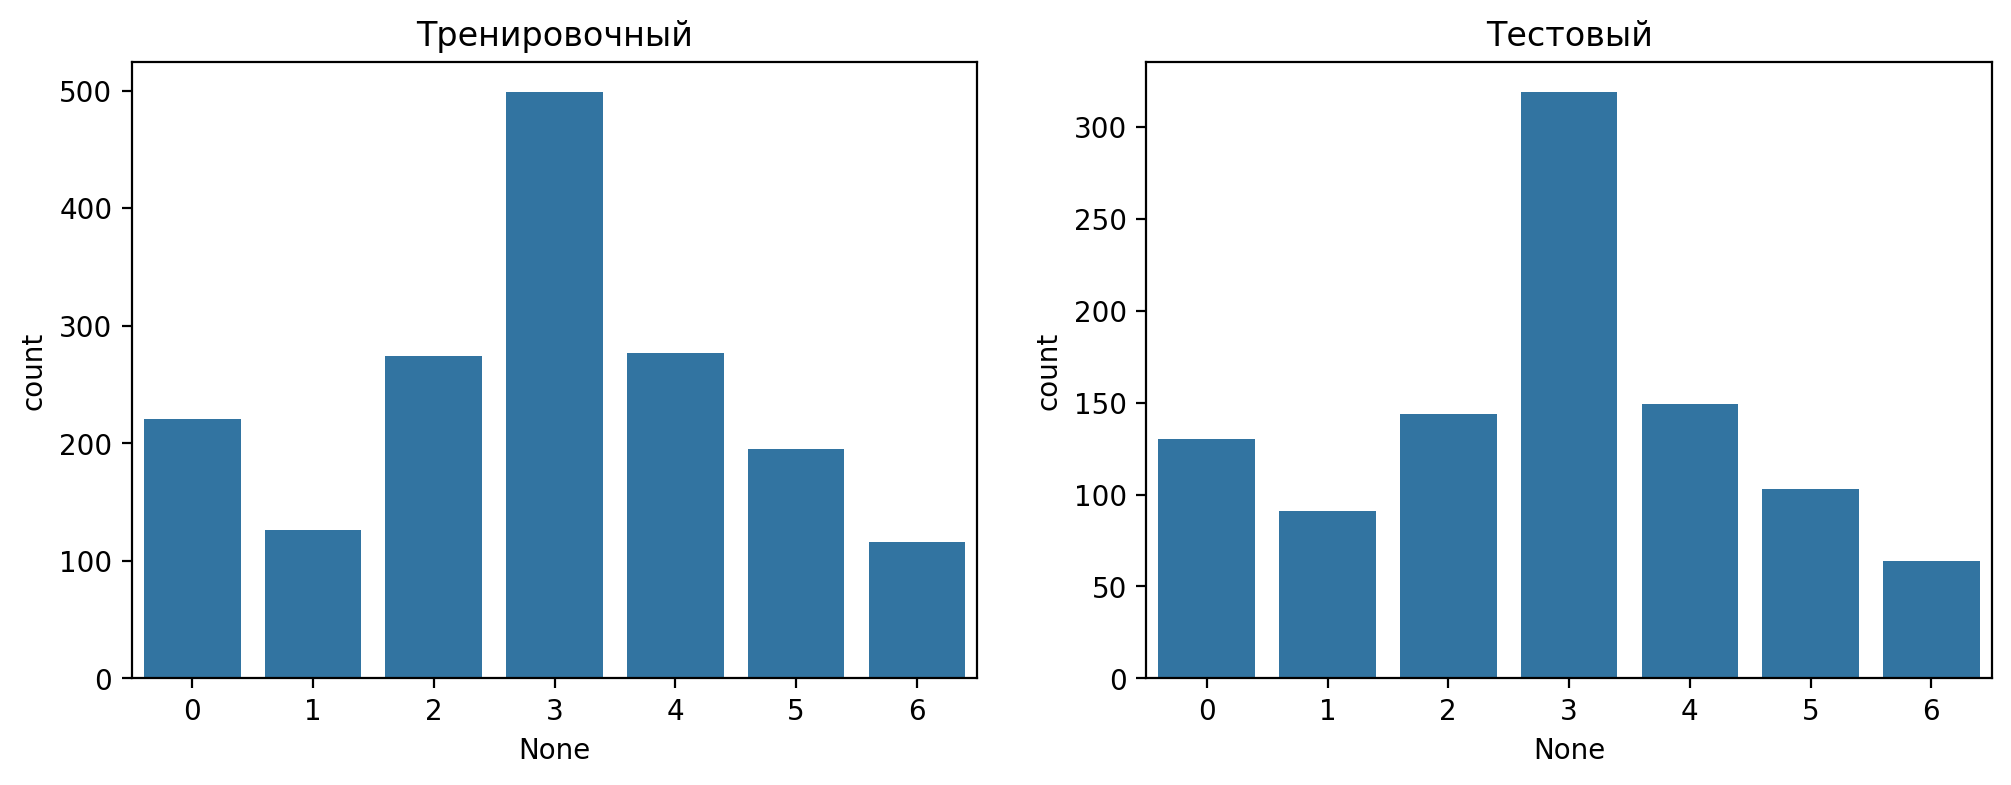

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
train_mask = data.train_mask + data.val_mask

sns.countplot(x = data.y[train_mask], ax = axs[0]);
axs[0].set_title('Тренировочный')
sns.countplot(x = data.y[data.test_mask], ax = axs[1]);
axs[1].set_title('Тестовый');

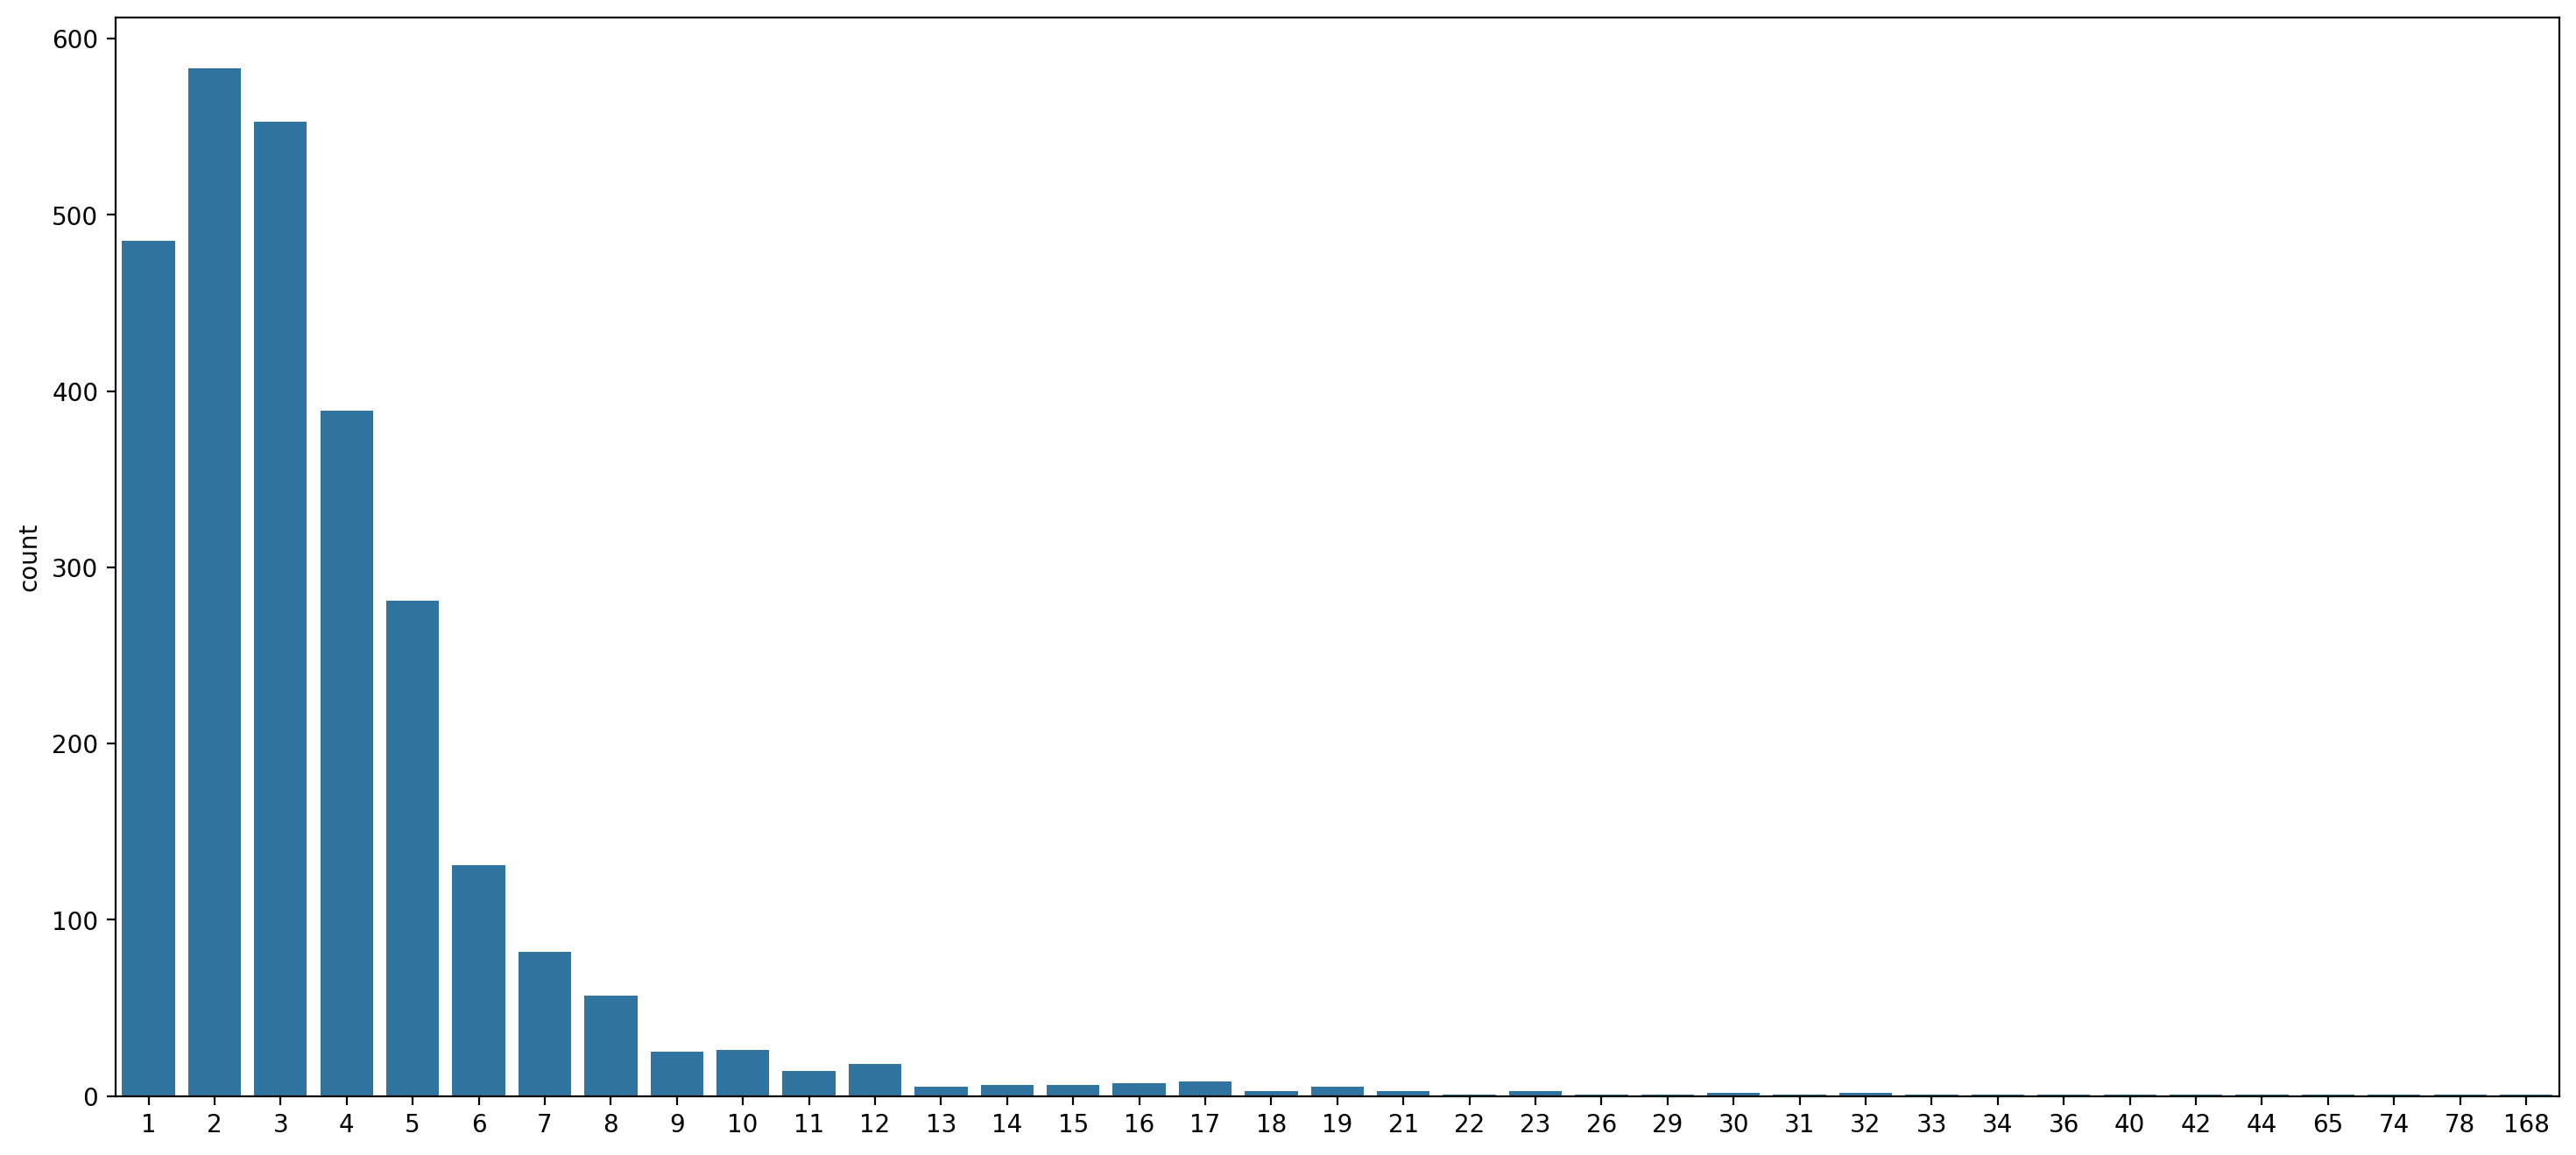

In [ ]:
plt.figure(figsize = (18, 8))
degrees = np.array(list(dict(G.degree()).values()))
sns.countplot(x = degrees);

# Построение нейронных сетей

In [ ]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
data =  data.to(device)
train_mask = data.train_mask + data.val_mask

In [ ]:
def accuracy(y_pred, y):
    return ((y_pred.argmax(-1) == y).sum() / len(y)).item()

In [ ]:
class Train():
  def __init__(self, model,
               lr = 0.001, n_epoch = 350, w_decay = 0.012):

      self.model = model
      self.lr = lr
      self.n_epoch = n_epoch
      self.w_decay = w_decay

      self.loss = []
      self.t_loss = []
      self.acc = []
      self.t_acc = []

      self.optimizer = optim.Adam(
                        model.parameters(),
                        lr = lr,
                        weight_decay = w_decay)

      self.scheduler = MultiStepLR(self.optimizer, milestones=[int(0.5 * n_epoch), int(0.6 * n_epoch), int(0.7 * n_epoch)], gamma=0.1)

  def start(self, data, show = 50):
    loss = nn.CrossEntropyLoss()

    for epoch in range(self.n_epoch + 1):
        train_mask = data.train_mask + data.val_mask

        y_pred = self.model(data.x, data.edge_index)
        output = loss(y_pred[train_mask], data.y[train_mask])
        output_test = loss(y_pred[data.test_mask], data.y[data.test_mask])

        self.loss.append(output.item())
        self.t_loss.append(output_test.item())
        self.acc.append(accuracy(y_pred[train_mask], data.y[train_mask]))
        self.t_acc.append(accuracy(y_pred[data.test_mask], data.y[data.test_mask]))

        if epoch % show == 0:
            print(f'Epoch {epoch:>4} | Train Loss: {self.loss[epoch]:.3f} | Train Acc: '
                  f'{self.acc[epoch]*100:>6.2f}% | Test Loss: {self.t_loss[epoch]:.3f} | '
                  f'Test Acc: {self.t_acc[epoch]*100:.2f}%')


        output.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.scheduler.step()


  def view_results(self):
      d = {'Accuracy' : [self.acc[-1], self.t_acc[-1]],
           'Loss' : [self.loss[-1], self.t_loss[-1]]}
      res = pd.DataFrame(d, index = ['train', 'test'])
      return res.round(3)

  def conf_matrix(self, data):
      y_pred = self.model(data.x, data.edge_index)
      y_pred = y_pred.argmax(-1)

      fig, axs = plt.subplots(1, 2, figsize=(12, 4))
      for ind, (mask, title) in enumerate([(data.train_mask + data.val_mask, 'train_result'), (data.test_mask, 'test_result')]):
          y, y_pred, mask = data.y.cpu(), y_pred.cpu(), mask.cpu()

          m = confusion_matrix(y[mask], y_pred[mask], labels = range(num_classes))
          sns.heatmap(m/m.sum(axis = 1)[:, None], annot = True, fmt = '.1%', ax = axs[ind]);
          axs[ind].set_title(title)

In [ ]:
def plots(tr, te, start = 200, title = ''):
    x = np.arange(0, len(tr))

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(x, tr, 'blue', label = 'train')
    axs[0].plot(x, te, 'red', label = 'test')
    axs[0].set_title(title + ' c 0 - ой эпохи')

    axs[1].plot(x[start:], tr[start:], 'blue', label = 'train')
    axs[1].plot(x[start:], te[start:], 'red', label = 'test')
    axs[1].set_title(title + f' c {start} - ой эпохи')

    axs[0].legend()
    axs[1].legend()

## 1)НС c линейными слоями

In [ ]:
model = nn.Sequential(
    nn.Linear(m, 250),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(250, 125),
    nn.ReLU(),
    nn.Dropout(0.1),

    nn.Linear(125, num_classes)
    ).to(device)

In [ ]:
lr = 0.001 #  скорость обучения
n_epoch = 1000 #  количество эпох
losses = []
losses_test = []

optimizer = optim.Adam(
            model.parameters(),
            lr = lr,
            weight_decay = 1e-2)

loss = nn.CrossEntropyLoss()
scheduler = MultiStepLR(optimizer, milestones=[900], gamma=0.1)

In [ ]:
for epoch in tqdm(range(n_epoch)):

    y_pred = model(data.x[train_mask])
    output = loss(y_pred, data.y[train_mask])

    losses.append(output.item())

    output.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

100%|██████████| 1000/1000 [00:04<00:00, 209.30it/s]


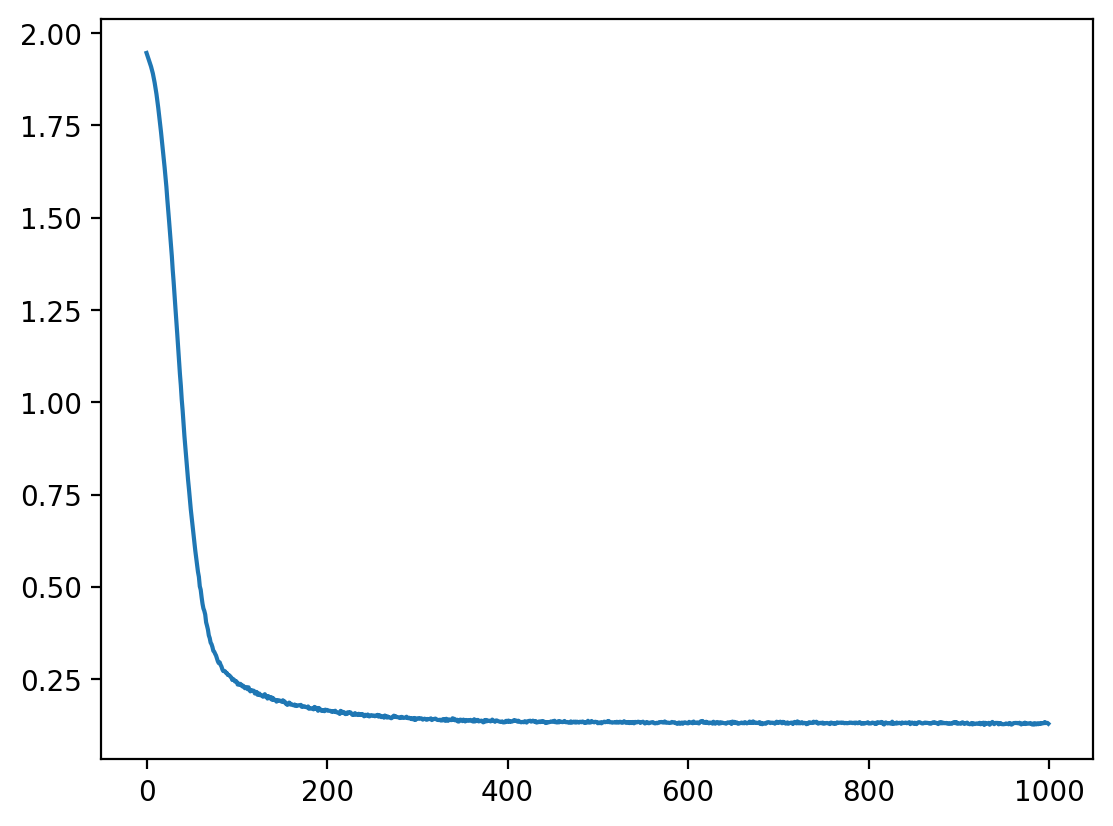

In [ ]:
plt.plot(losses);

In [ ]:
y_pred_test = model(data.x[data.test_mask])
loss(y_pred_test, data.y[data.test_mask]).item()

0.7615888714790344

In [ ]:
y_pred = model(data.x[train_mask])
y = data.y[train_mask]
accuracy(y_pred, y)

0.9964870810508728

In [ ]:
y_pred_test = model(data.x[data.test_mask])
y_test = data.y[data.test_mask]
accuracy(y_pred_test, y_test)

0.7600000500679016

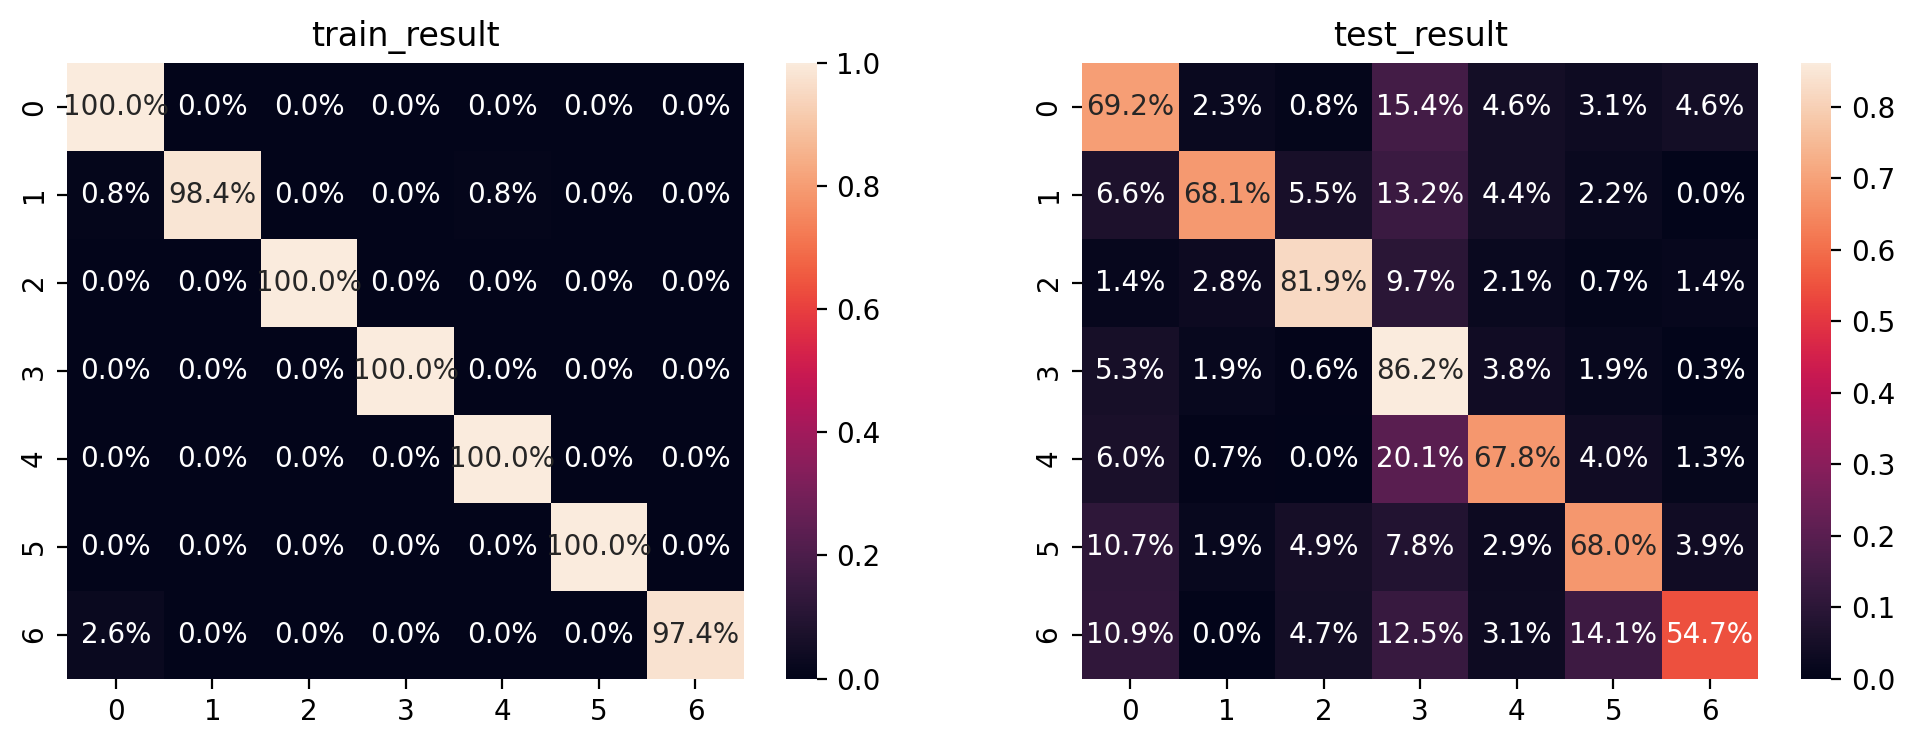

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

y_pred = model(data.x).argmax(-1)
y = data.y

for ind, (mask, title) in enumerate([(data.train_mask + data.val_mask, 'train_result'), (data.test_mask, 'test_result')]):
    y, y_pred, mask = data.y.cpu(), y_pred.cpu(), mask.cpu()

    ma = confusion_matrix(y[mask], y_pred[mask], labels = range(num_classes))
    sns.heatmap(ma/ma.sum(axis = 1)[:, None], annot = True, fmt = '.1%', ax = axs[ind]);
    axs[ind].set_title(title)

## 2)НС сo слоями conv.GCNConv

In [ ]:
class GCN(nn.Module):
    def __init__(self, n_features, num_classes):
        super().__init__()
        self.c1 = GCNConv(n_features, 400)
        self.c2 = GCNConv(400, 100)
        self.l1 = Linear(100, num_classes)

    def forward(self, X, edge_index):
        res = self.c1(X, edge_index).relu()
        res = F.dropout(res, p=0.1)
        res = self.c2(res, edge_index).relu()
        res = F.dropout(res, p=0.1)

        res = self.l1(res)

        return res

In [ ]:
model_gcn = GCN(n_features = m, num_classes = num_classes).to(device)

gcn_train = Train(model_gcn,
                  w_decay = 1e-2,
                  n_epoch = 1000)
gcn_train.start(data)

Epoch    0 | Train Loss: 1.951 | Train Acc:   7.79% | Test Loss: 1.949 | Test Acc: 9.00%
Epoch   50 | Train Loss: 0.685 | Train Acc:  82.44% | Test Loss: 0.776 | Test Acc: 77.90%
Epoch  100 | Train Loss: 0.342 | Train Acc:  93.15% | Test Loss: 0.474 | Test Acc: 88.50%
Epoch  150 | Train Loss: 0.294 | Train Acc:  93.68% | Test Loss: 0.445 | Test Acc: 88.00%
Epoch  200 | Train Loss: 0.273 | Train Acc:  94.38% | Test Loss: 0.429 | Test Acc: 88.60%
Epoch  250 | Train Loss: 0.259 | Train Acc:  94.26% | Test Loss: 0.428 | Test Acc: 88.60%
Epoch  300 | Train Loss: 0.245 | Train Acc:  94.79% | Test Loss: 0.431 | Test Acc: 88.10%
Epoch  350 | Train Loss: 0.241 | Train Acc:  94.79% | Test Loss: 0.426 | Test Acc: 87.40%
Epoch  400 | Train Loss: 0.231 | Train Acc:  95.49% | Test Loss: 0.433 | Test Acc: 87.50%
Epoch  450 | Train Loss: 0.232 | Train Acc:  94.91% | Test Loss: 0.434 | Test Acc: 87.60%
Epoch  500 | Train Loss: 0.231 | Train Acc:  95.32% | Test Loss: 0.432 | Test Acc: 87.30%
Epoch  550 

In [ ]:
gcn_train.view_results()

,Accuracy,Loss
train,0.952,0.229
test,0.878,0.431


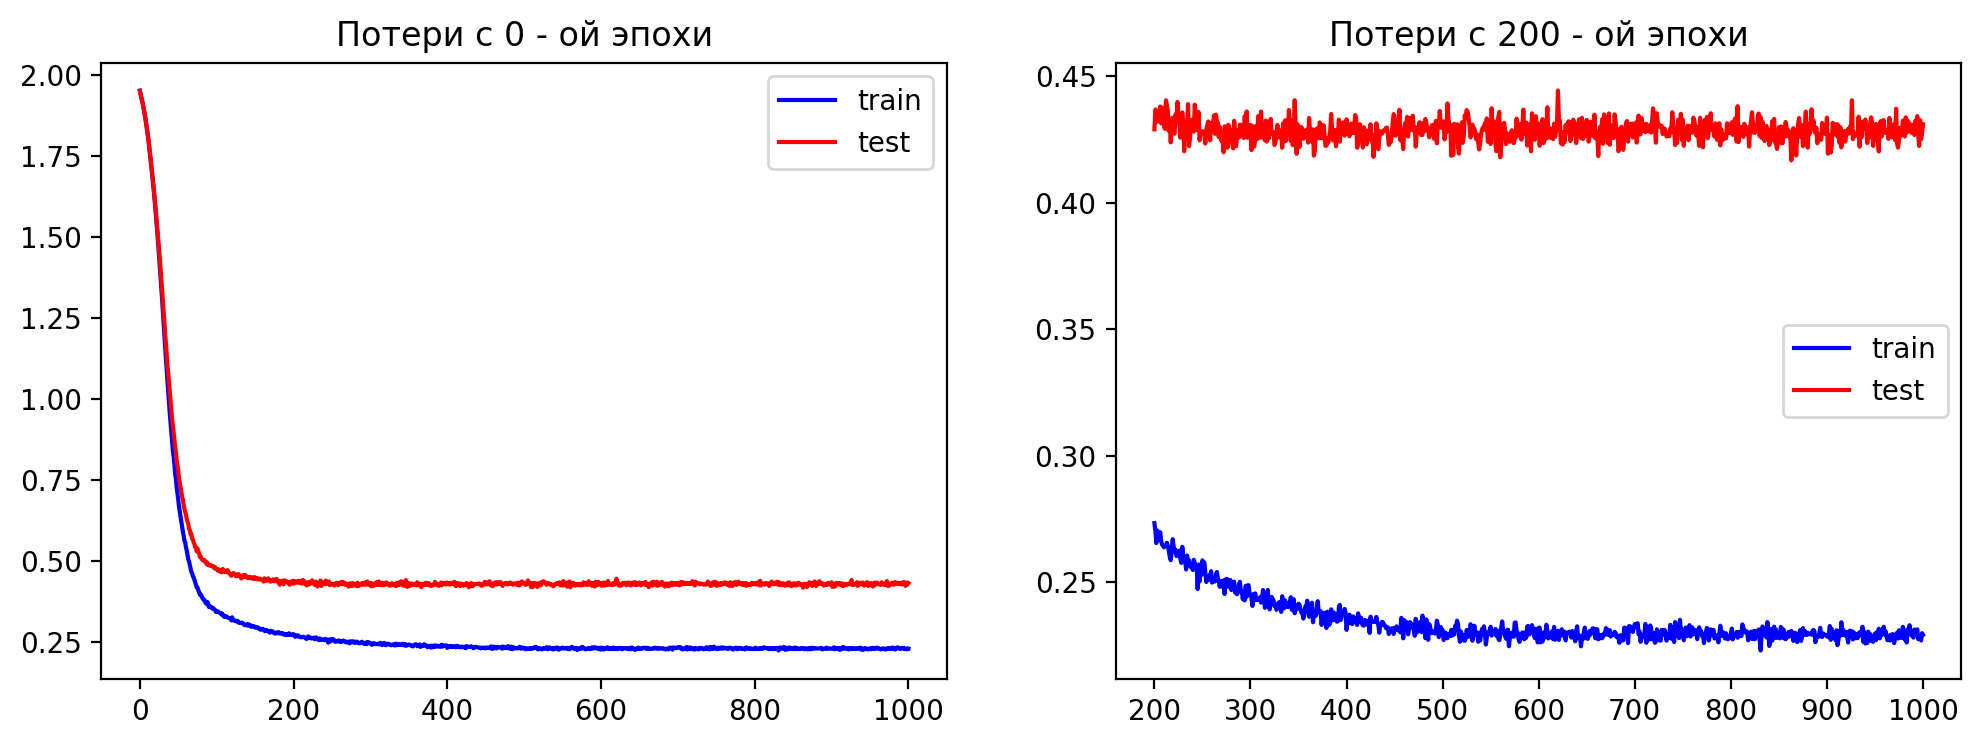

In [ ]:
plots(gcn_train.loss, gcn_train.t_loss, title = 'Потери')

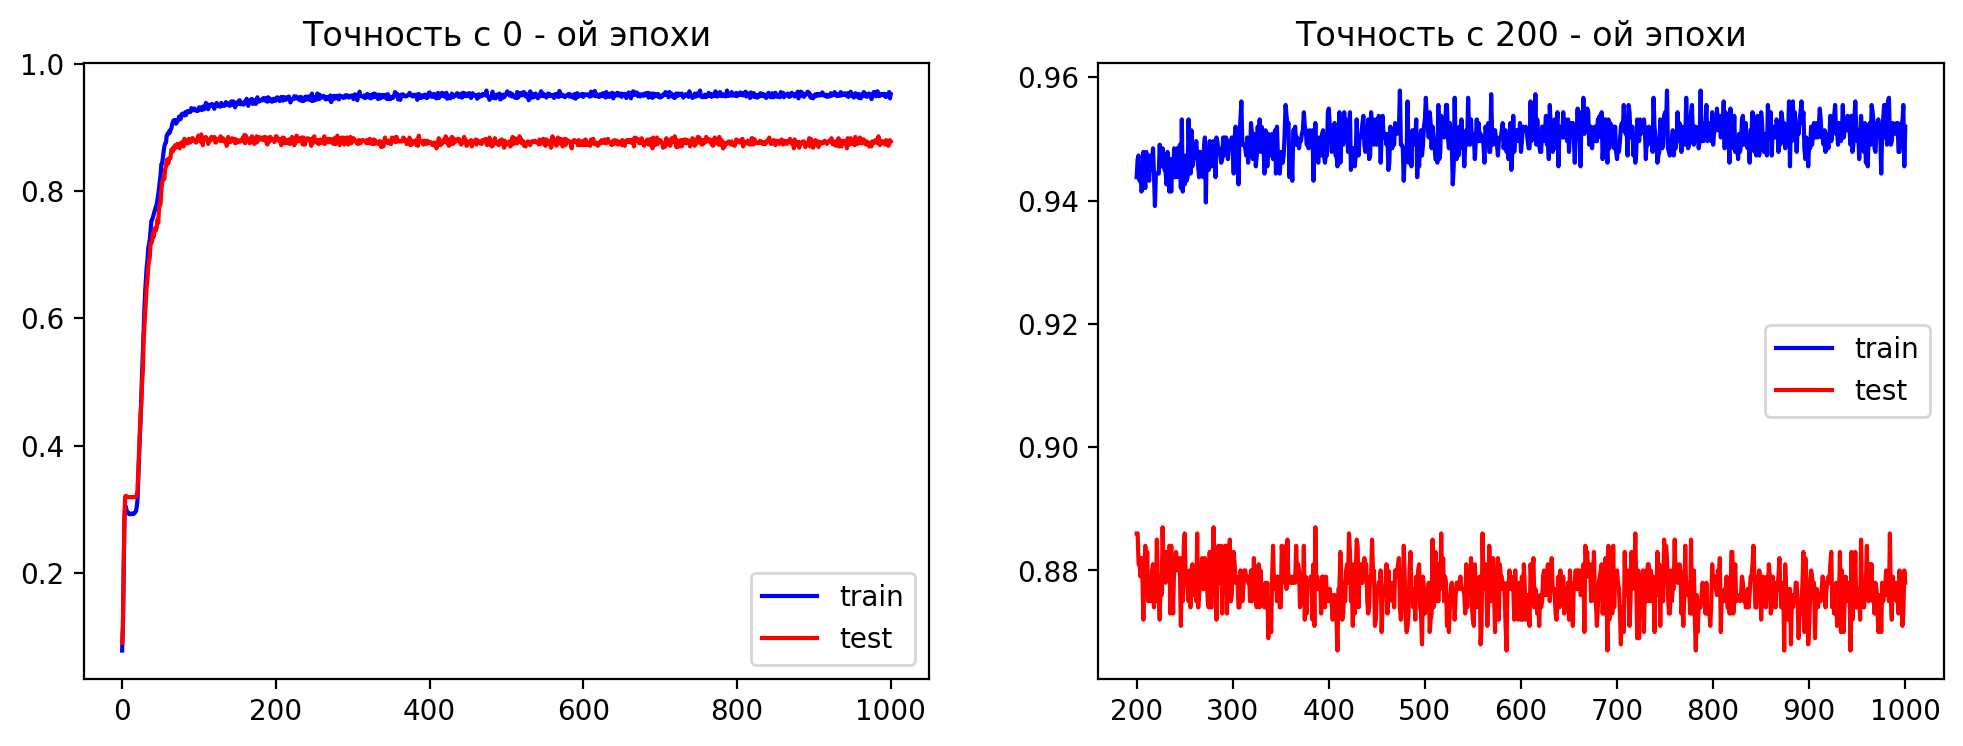

In [ ]:
plots(gcn_train.acc, gcn_train.t_acc, title = 'Точность')

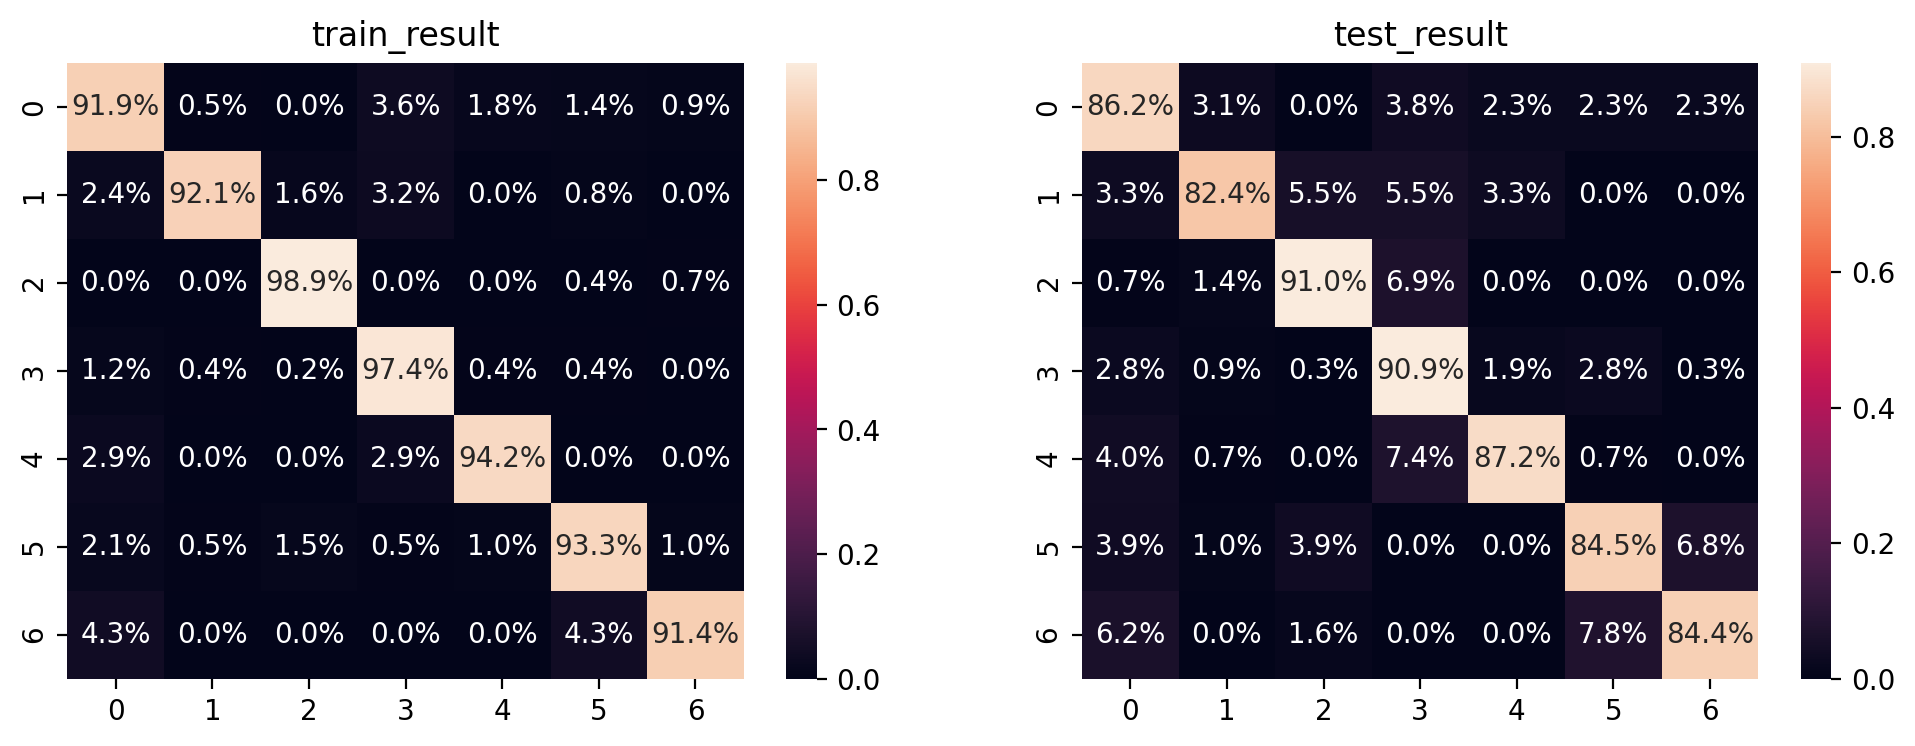

In [ ]:
gcn_train.conf_matrix(data)

## 3)НС сo слоями conv.SAGEConv

In [ ]:
class GCN_Sage(nn.Module):
    def __init__(self, n_features, num_classes, aggr = 'mean'):
        super().__init__()
        self.c1 = SAGEConv(n_features, 400, aggr = aggr)
        self.c2 = SAGEConv(400, 100, aggr = aggr)
        self.c3 = SAGEConv(100, num_classes, aggr = aggr)

    def forward(self, X, edge_index):
        res = self.c1(X, edge_index).relu()
        res = F.dropout(res, p=0.3)
        res = self.c2(res, edge_index).relu()
        res = F.dropout(res, p=0.1)
        res = self.c3(res, edge_index)

        return res

### a)c агрегацией 'mean'

In [ ]:
model_sage = GCN_Sage(n_features = m, num_classes = num_classes).to(device)

sage_train = Train(model_sage,
                   w_decay = 2.3e-2,
                  n_epoch = 1000)

sage_train.start(data)

Epoch    0 | Train Loss: 1.944 | Train Acc:  11.01% | Test Loss: 1.945 | Test Acc: 10.40%
Epoch   50 | Train Loss: 0.320 | Train Acc:  93.44% | Test Loss: 0.469 | Test Acc: 87.30%
Epoch  100 | Train Loss: 0.248 | Train Acc:  95.20% | Test Loss: 0.436 | Test Acc: 87.60%
Epoch  150 | Train Loss: 0.224 | Train Acc:  95.55% | Test Loss: 0.432 | Test Acc: 87.90%
Epoch  200 | Train Loss: 0.214 | Train Acc:  95.96% | Test Loss: 0.435 | Test Acc: 87.10%
Epoch  250 | Train Loss: 0.205 | Train Acc:  96.37% | Test Loss: 0.436 | Test Acc: 87.60%
Epoch  300 | Train Loss: 0.203 | Train Acc:  96.37% | Test Loss: 0.433 | Test Acc: 87.70%
Epoch  350 | Train Loss: 0.201 | Train Acc:  96.25% | Test Loss: 0.429 | Test Acc: 87.40%
Epoch  400 | Train Loss: 0.203 | Train Acc:  96.25% | Test Loss: 0.429 | Test Acc: 87.60%
Epoch  450 | Train Loss: 0.197 | Train Acc:  96.37% | Test Loss: 0.421 | Test Acc: 87.90%
Epoch  500 | Train Loss: 0.200 | Train Acc:  96.37% | Test Loss: 0.430 | Test Acc: 87.40%
Epoch  550

In [ ]:
sage_train.view_results()

,Accuracy,Loss
train,0.965,0.200
test,0.885,0.427


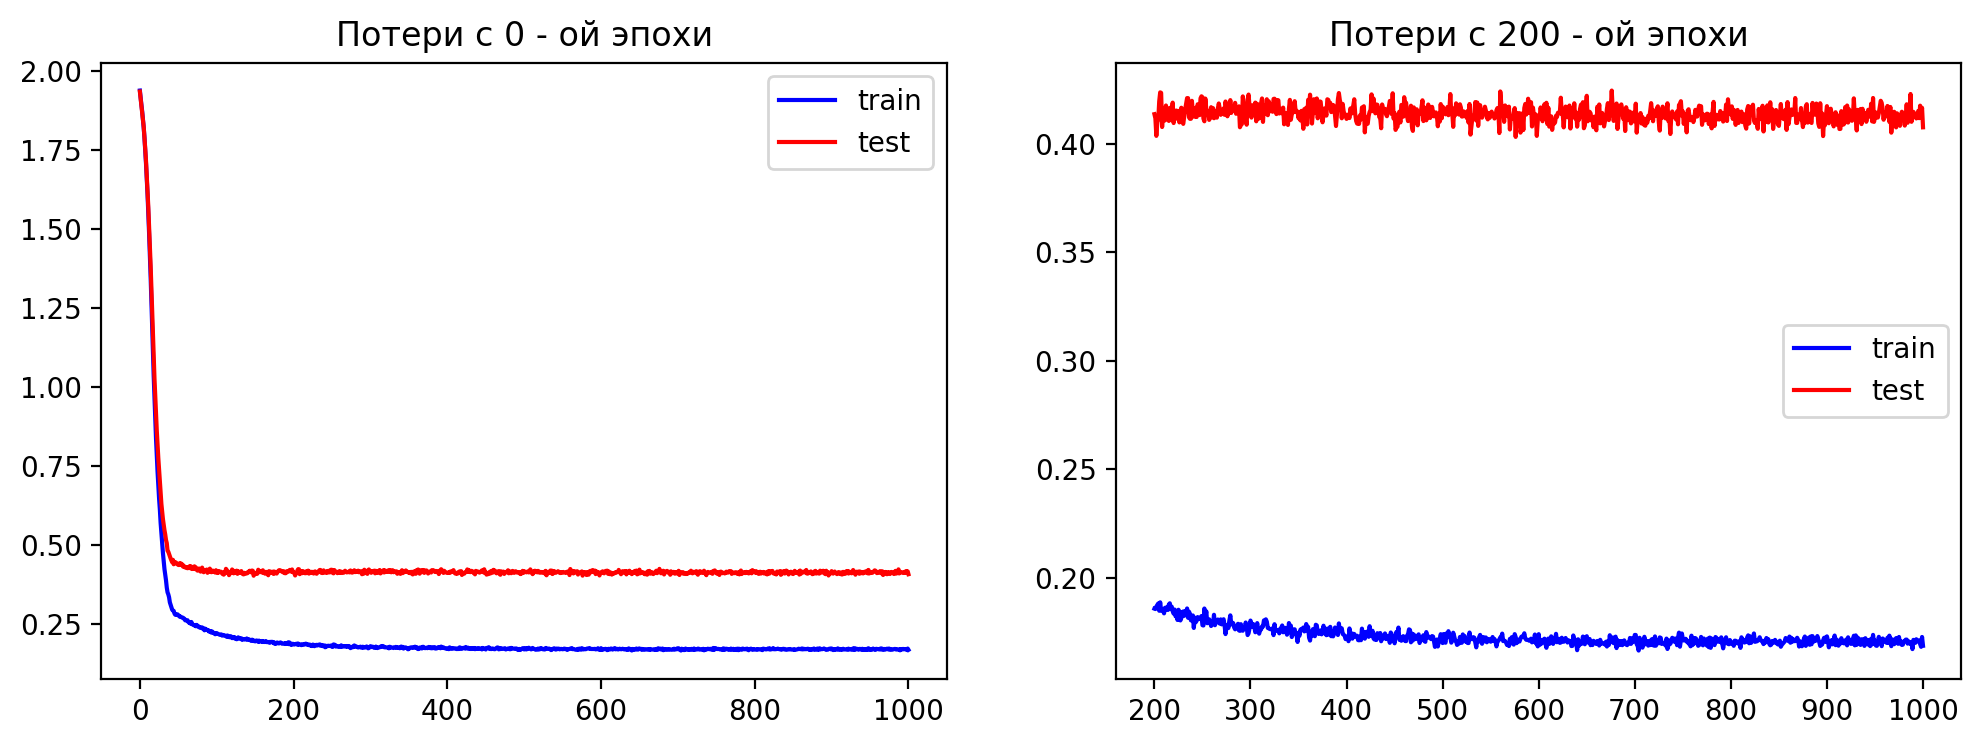

In [ ]:
plots(sage_train.loss, sage_train.t_loss, title = 'Потери')

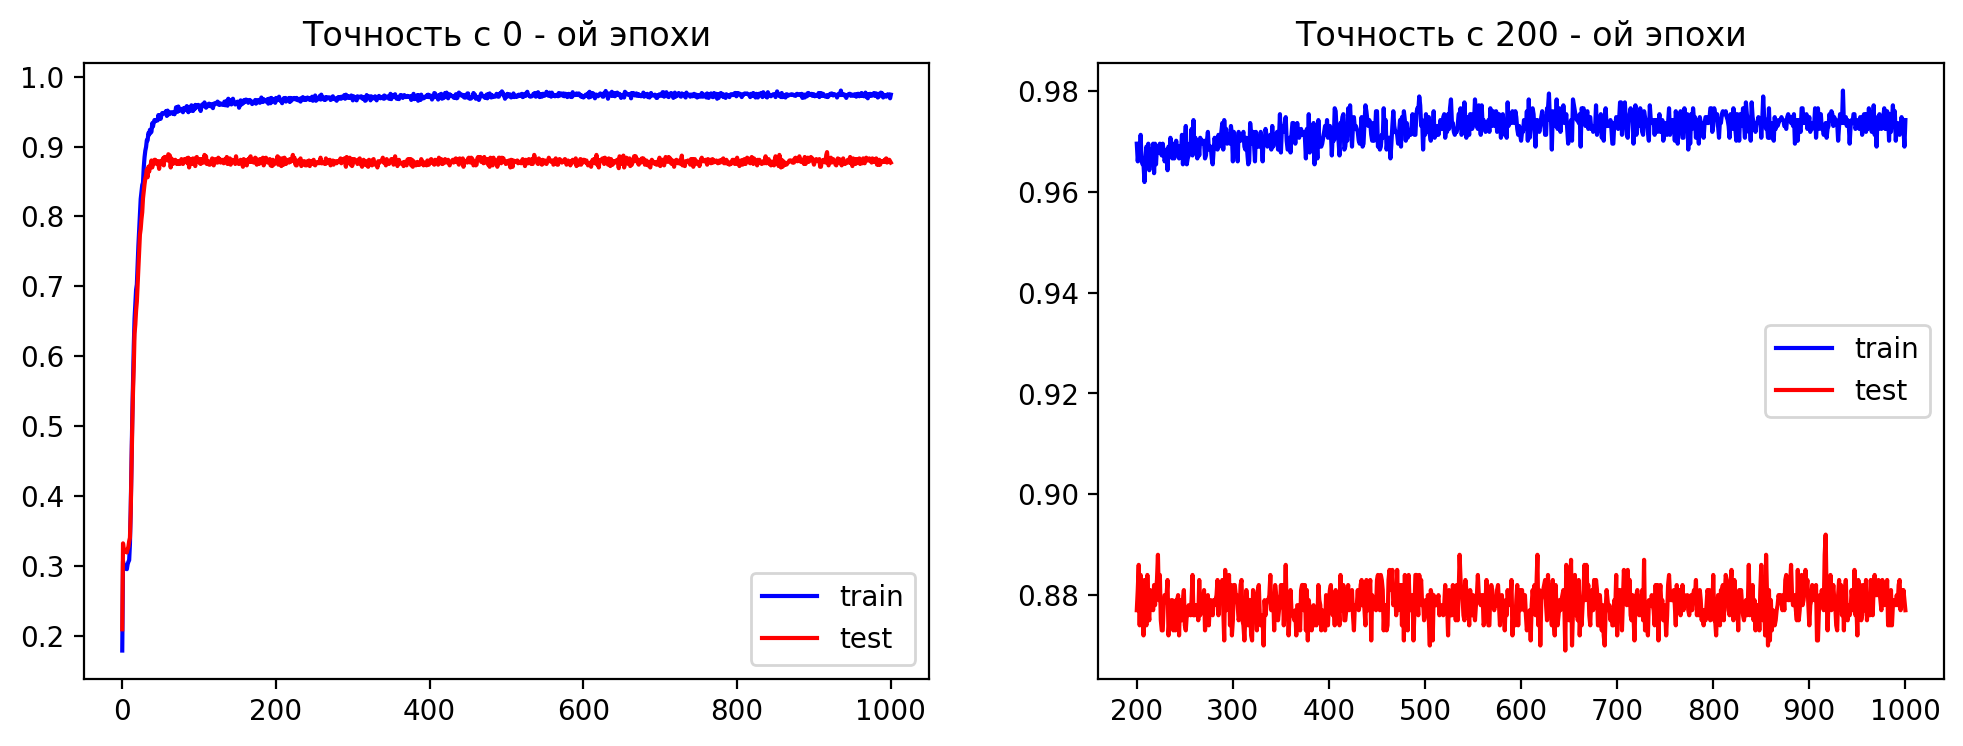

In [ ]:
plots(sage_train.acc, sage_train.t_acc, title = 'Точность')

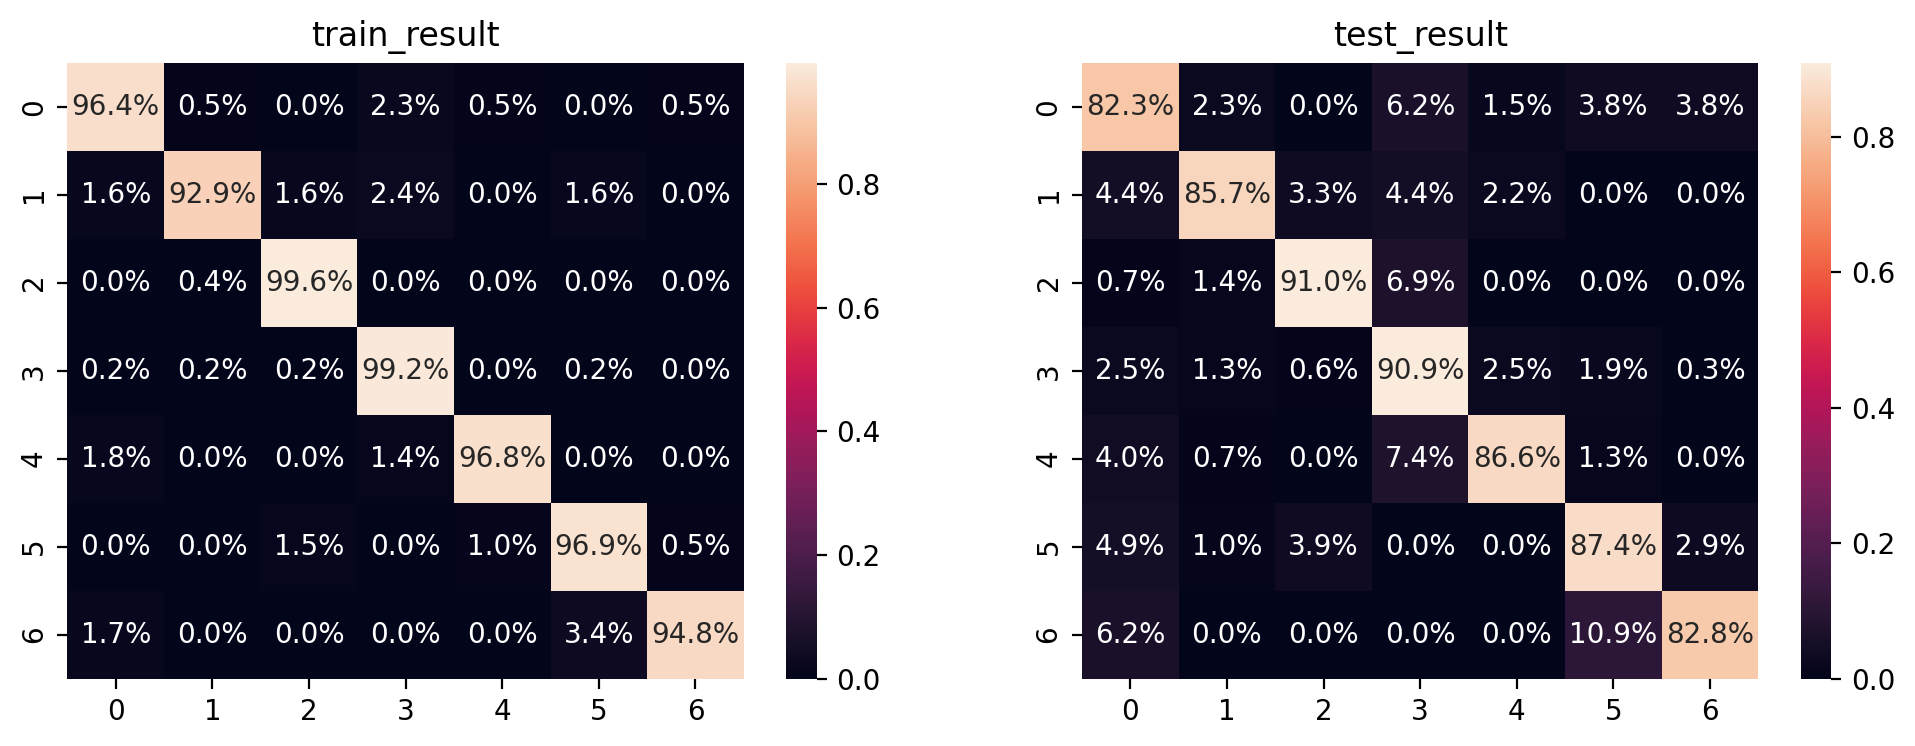

In [ ]:
sage_train.conf_matrix(data)

### б)c агрегацией 'max'

In [ ]:
model_sage = GCN_Sage(n_features = m, num_classes = num_classes, aggr = 'max').to(device)

sage_train = Train(model_sage,
                   w_decay = 3e-2,
                  n_epoch = 1000)

sage_train.start(data)

/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch    0 | Train Loss: 1.970 | Train Acc:  11.65% | Test Loss: 1.970 | Test Acc: 10.60%
Epoch   50 | Train Loss: 0.303 | Train Acc:  92.62% | Test Loss: 0.490 | Test Acc: 84.90%
Epoch  100 | Train Loss: 0.231 | Train Acc:  94.67% | Test Loss: 0.470 | Test Acc: 85.10%
Epoch  150 | Train Loss: 0.209 | Train Acc:  94.96% | Test Loss: 0.469 | Test Acc: 85.10%
Epoch  200 | Train Loss: 0.198 | Train Acc:  95.32% | Test Loss: 0.457 | Test Acc: 85.80%
Epoch  250 | Train Loss: 0.193 | Train Acc:  95.20% | Test Loss: 0.448 | Test Acc: 85.60%
Epoch  300 | Train Loss: 0.191 | Train Acc:  95.73% | Test Loss: 0.460 | Test Acc: 85.80%
Epoch  350 | Train Loss: 0.185 | Train Acc:  96.19% | Test Loss: 0.454 | Test Acc: 86.10%
Epoch  400 | Train Loss: 0.188 | Train Acc:  96.49% | Test Loss: 0.461 | Test Acc: 86.20%
Epoch  450 | Train Loss: 0.183 | Train Acc:  96.02% | Test Loss: 0.449 | Test Acc: 86.00%
Epoch  500 | Train Loss: 0.184 | Train Acc:  96.37% | Test Loss: 0.465 | Test Acc: 85.00%
Epoch  550

In [ ]:
sage_train.view_results()

,Accuracy,Loss
train,0.964,0.180
test,0.860,0.445


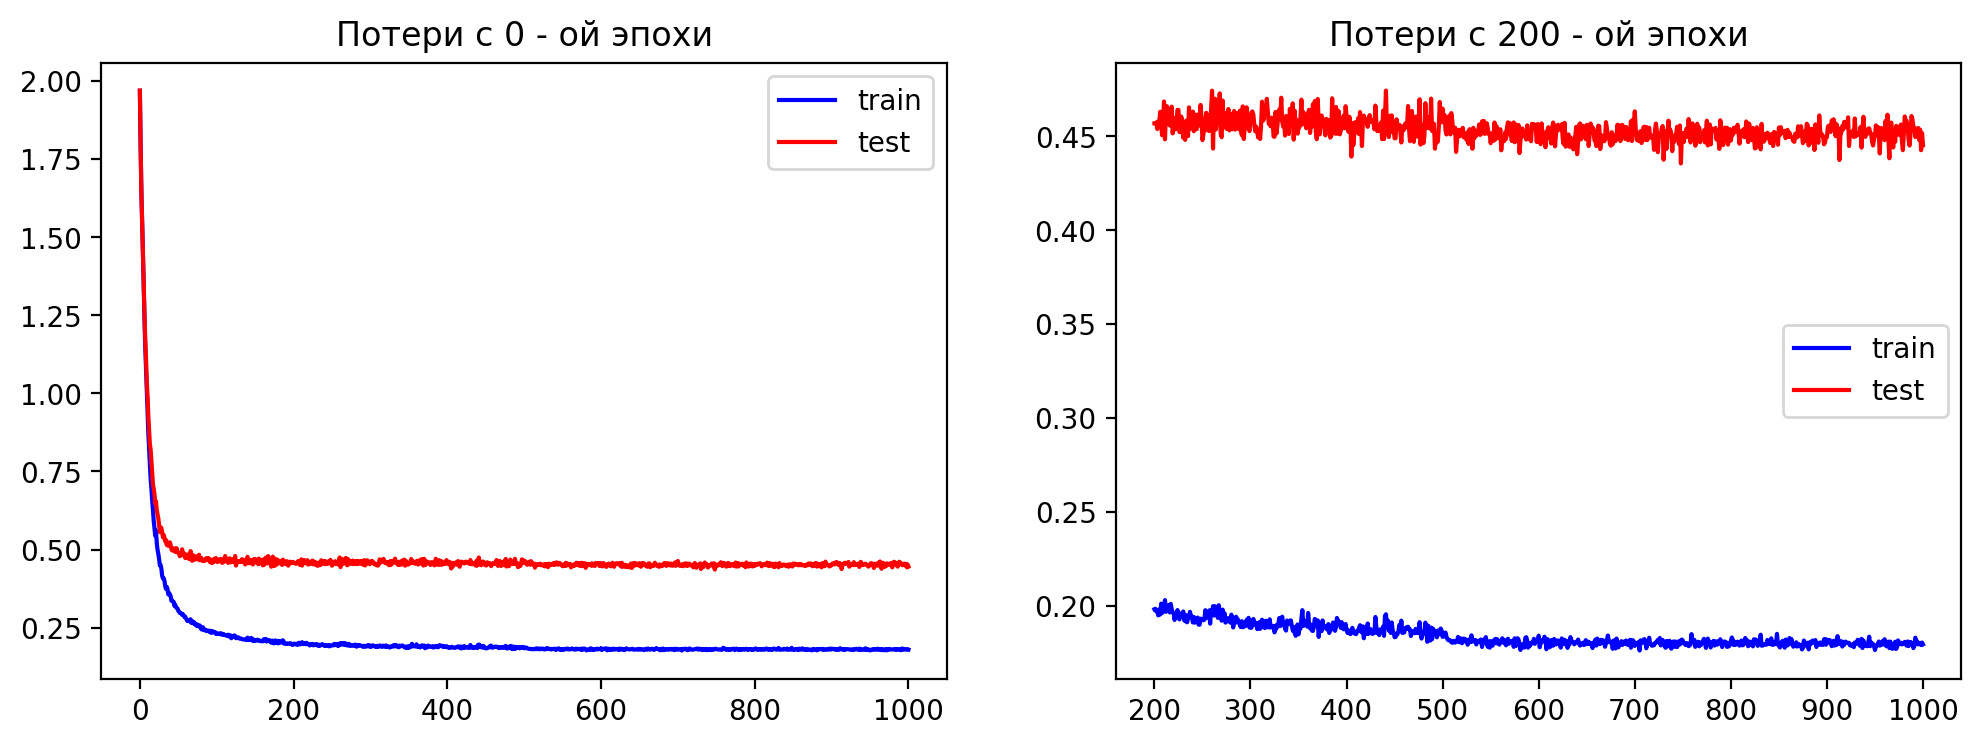

In [ ]:
plots(sage_train.loss, sage_train.t_loss, title = 'Потери')

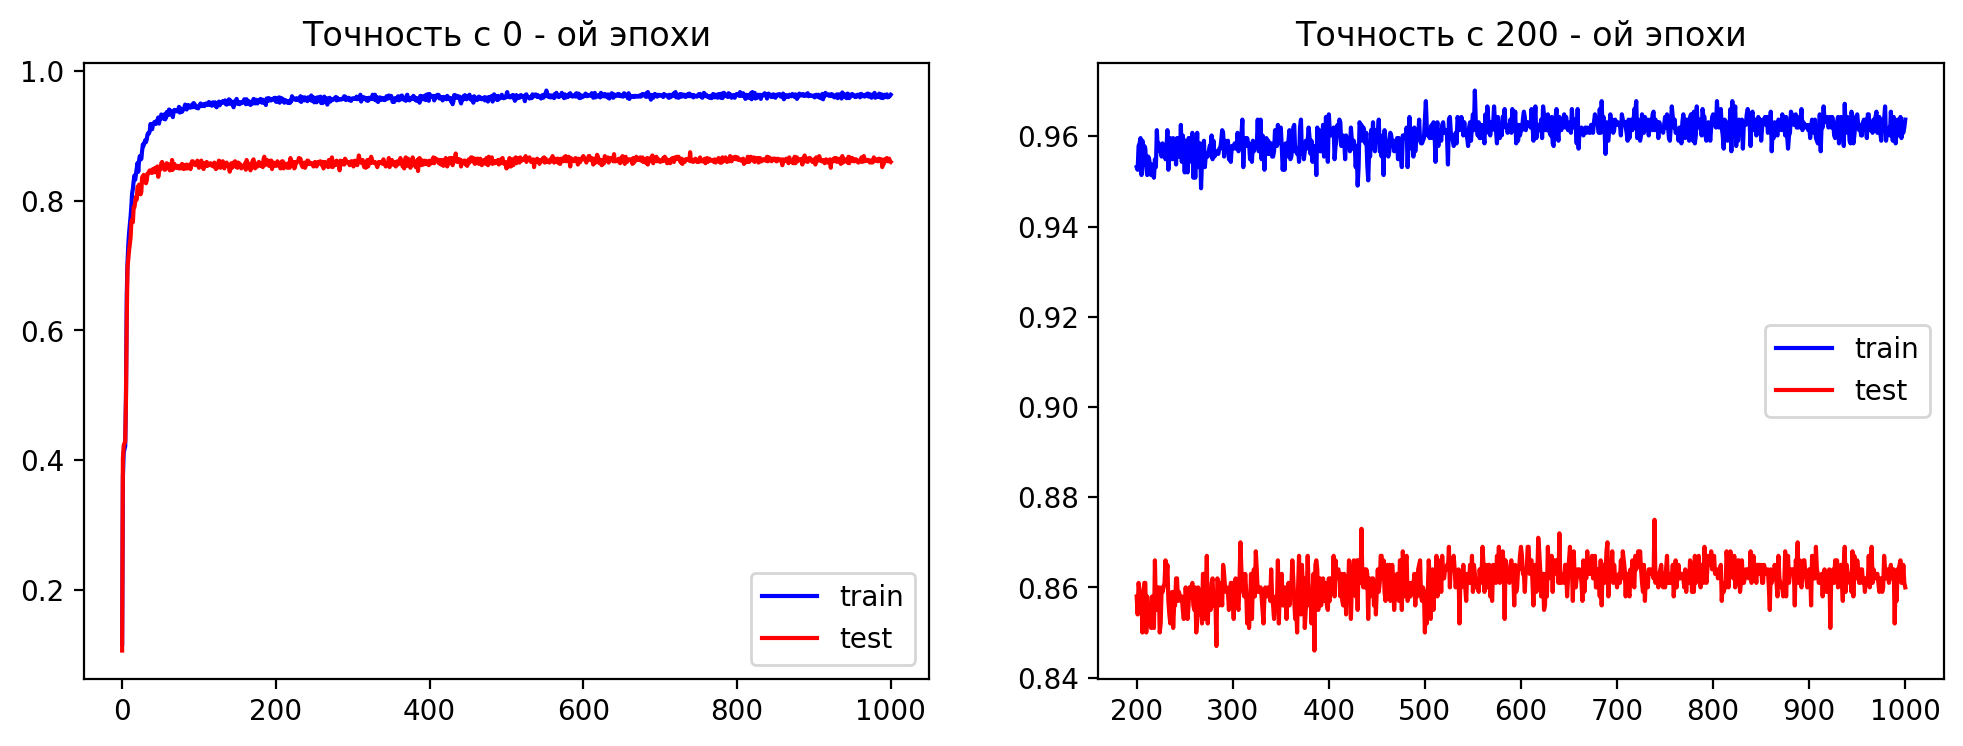

In [ ]:
plots(sage_train.acc, sage_train.t_acc, title = 'Точность')

/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


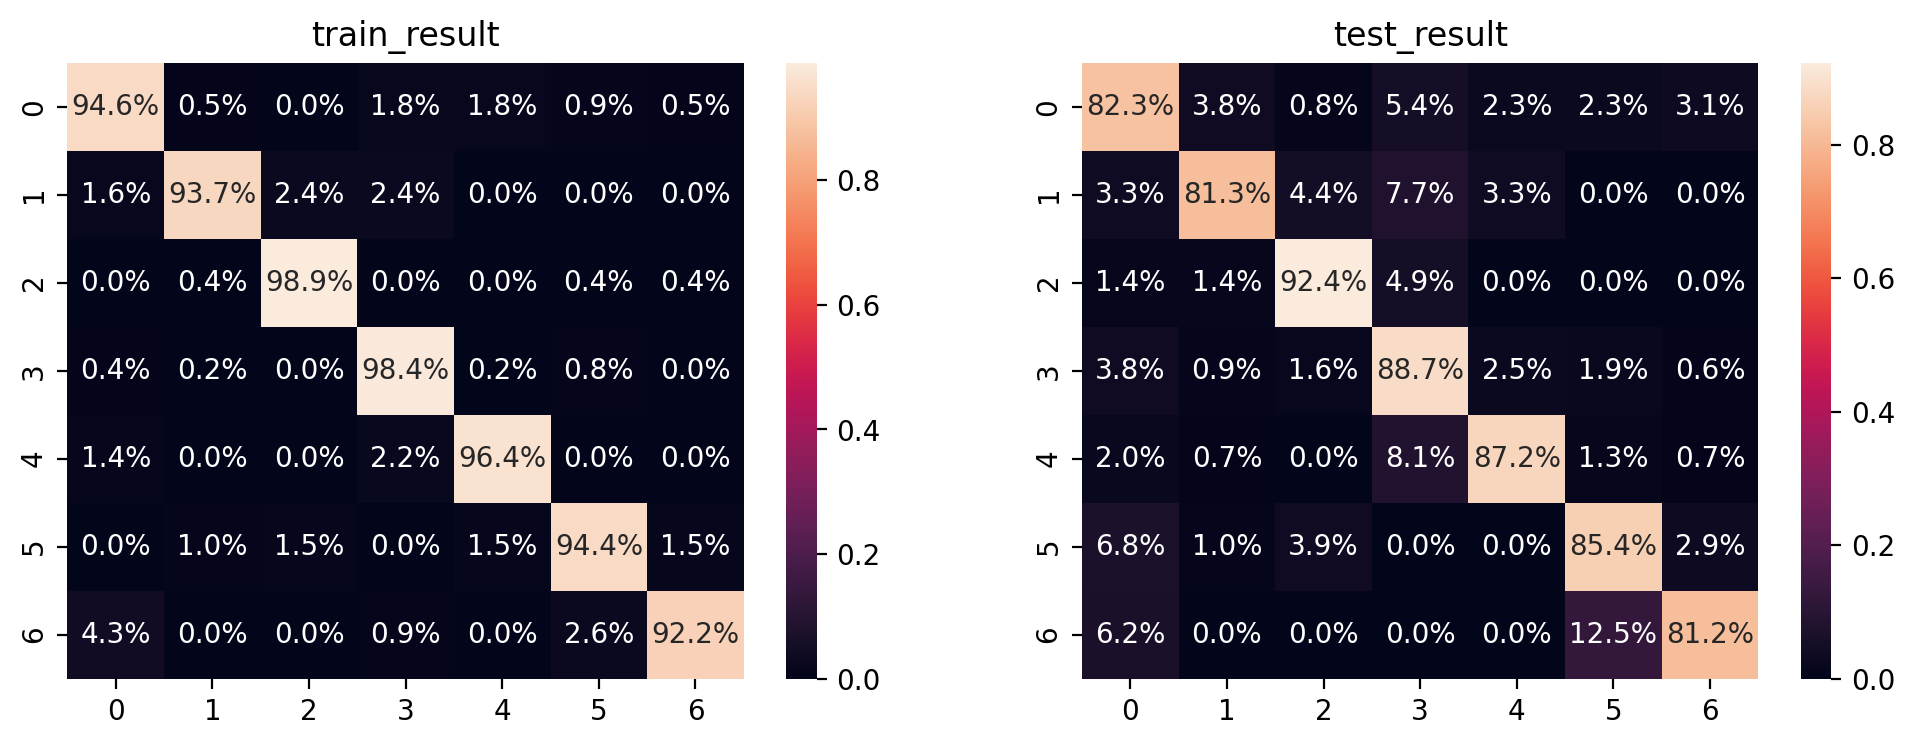

In [ ]:
sage_train.conf_matrix(data)

## 5)НС сo слоями conv.GATConv

In [ ]:
class GCN_Gat(nn.Module):
    def __init__(self, n_features, num_classes, head1 = 1, head2 = 1):
        super().__init__()
        self.c1 = GATConv(n_features, 500, heads = head1)
        self.c2 = GATConv(500 * head1, 250, heads = head2)

        self.l1 = Linear(250 * head2, num_classes)

    def forward(self, X, edge_index):
        res = self.c1(X, edge_index).relu()
        res = F.dropout(res, p=0.35)

        res = self.c2(res, edge_index).relu()
        res = F.dropout(res, p=0.25)

        res = self.l1(res)

        return res

### а)1 head

In [ ]:
model_gat = GCN_Gat(n_features = m, num_classes = num_classes, head1 = 1, head2 = 1).to(device)
gat_train = Train(model_gat,
                  w_decay = 1.5e-2,
                  n_epoch = 1000)

gat_train.start(data)

Epoch    0 | Train Loss: 1.952 | Train Acc:   9.31% | Test Loss: 1.952 | Test Acc: 9.80%
Epoch   50 | Train Loss: 0.665 | Train Acc:  81.85% | Test Loss: 0.760 | Test Acc: 77.10%
Epoch  100 | Train Loss: 0.297 | Train Acc:  93.68% | Test Loss: 0.481 | Test Acc: 86.70%
Epoch  150 | Train Loss: 0.244 | Train Acc:  94.96% | Test Loss: 0.478 | Test Acc: 86.40%
Epoch  200 | Train Loss: 0.224 | Train Acc:  95.49% | Test Loss: 0.480 | Test Acc: 86.30%
Epoch  250 | Train Loss: 0.220 | Train Acc:  95.90% | Test Loss: 0.476 | Test Acc: 86.40%
Epoch  300 | Train Loss: 0.210 | Train Acc:  96.25% | Test Loss: 0.480 | Test Acc: 86.60%
Epoch  350 | Train Loss: 0.217 | Train Acc:  95.49% | Test Loss: 0.502 | Test Acc: 86.10%
Epoch  400 | Train Loss: 0.204 | Train Acc:  96.31% | Test Loss: 0.485 | Test Acc: 86.60%
Epoch  450 | Train Loss: 0.209 | Train Acc:  95.61% | Test Loss: 0.488 | Test Acc: 86.00%
Epoch  500 | Train Loss: 0.209 | Train Acc:  95.61% | Test Loss: 0.481 | Test Acc: 87.10%
Epoch  550 

In [ ]:
gat_train.view_results()

,Accuracy,Loss
train,0.960,0.207
test,0.861,0.493


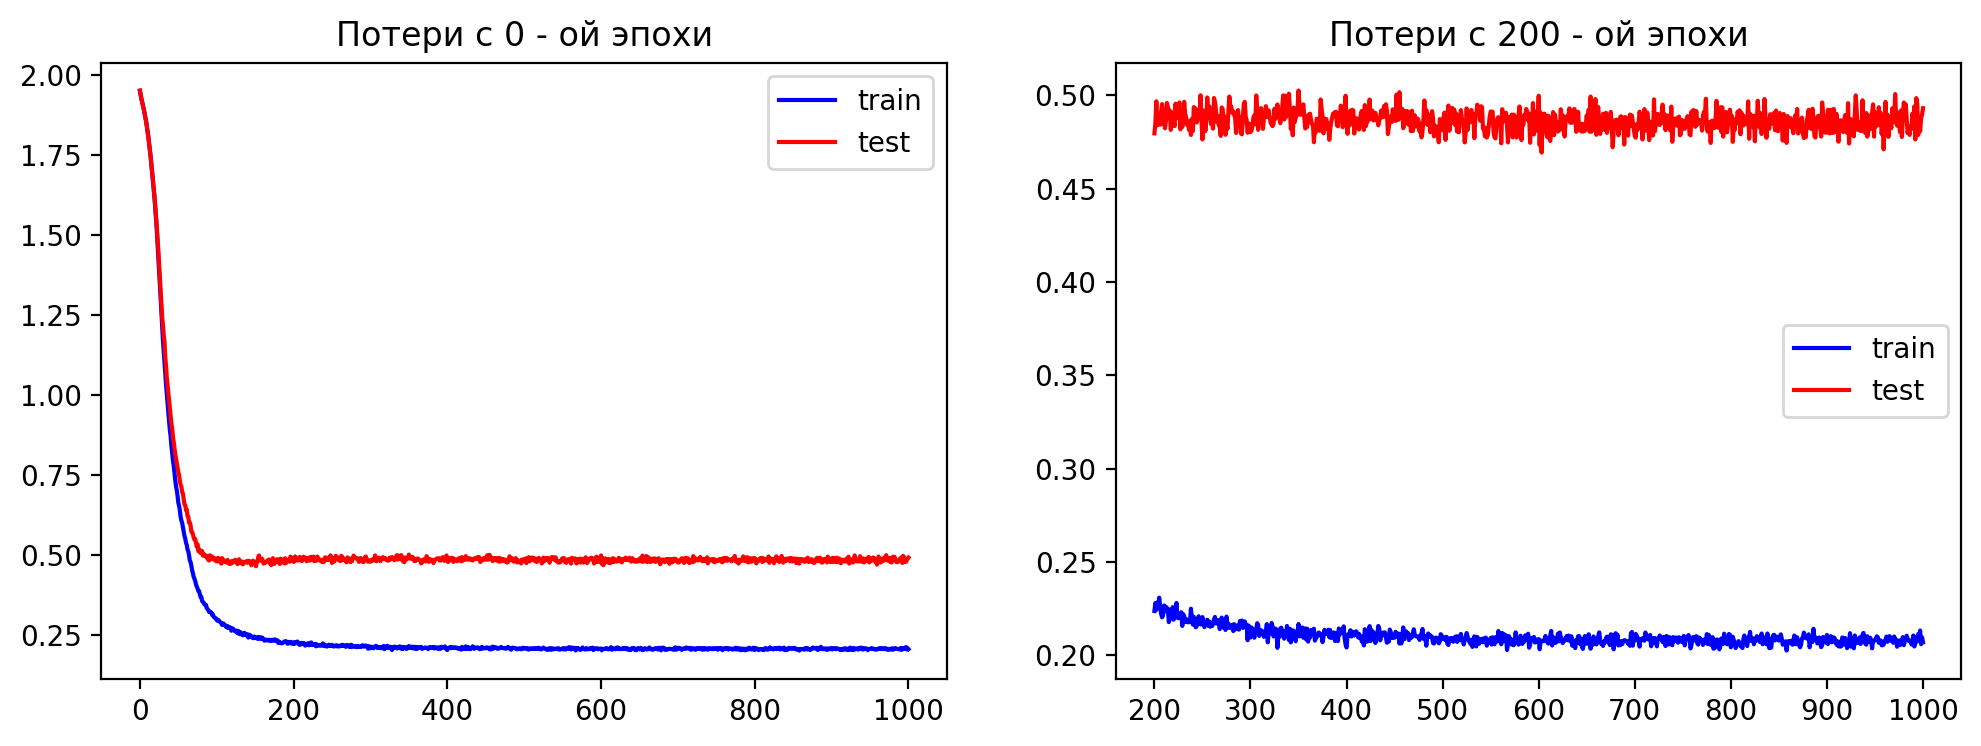

In [ ]:
plots(gat_train.loss, gat_train.t_loss, title = 'Потери')

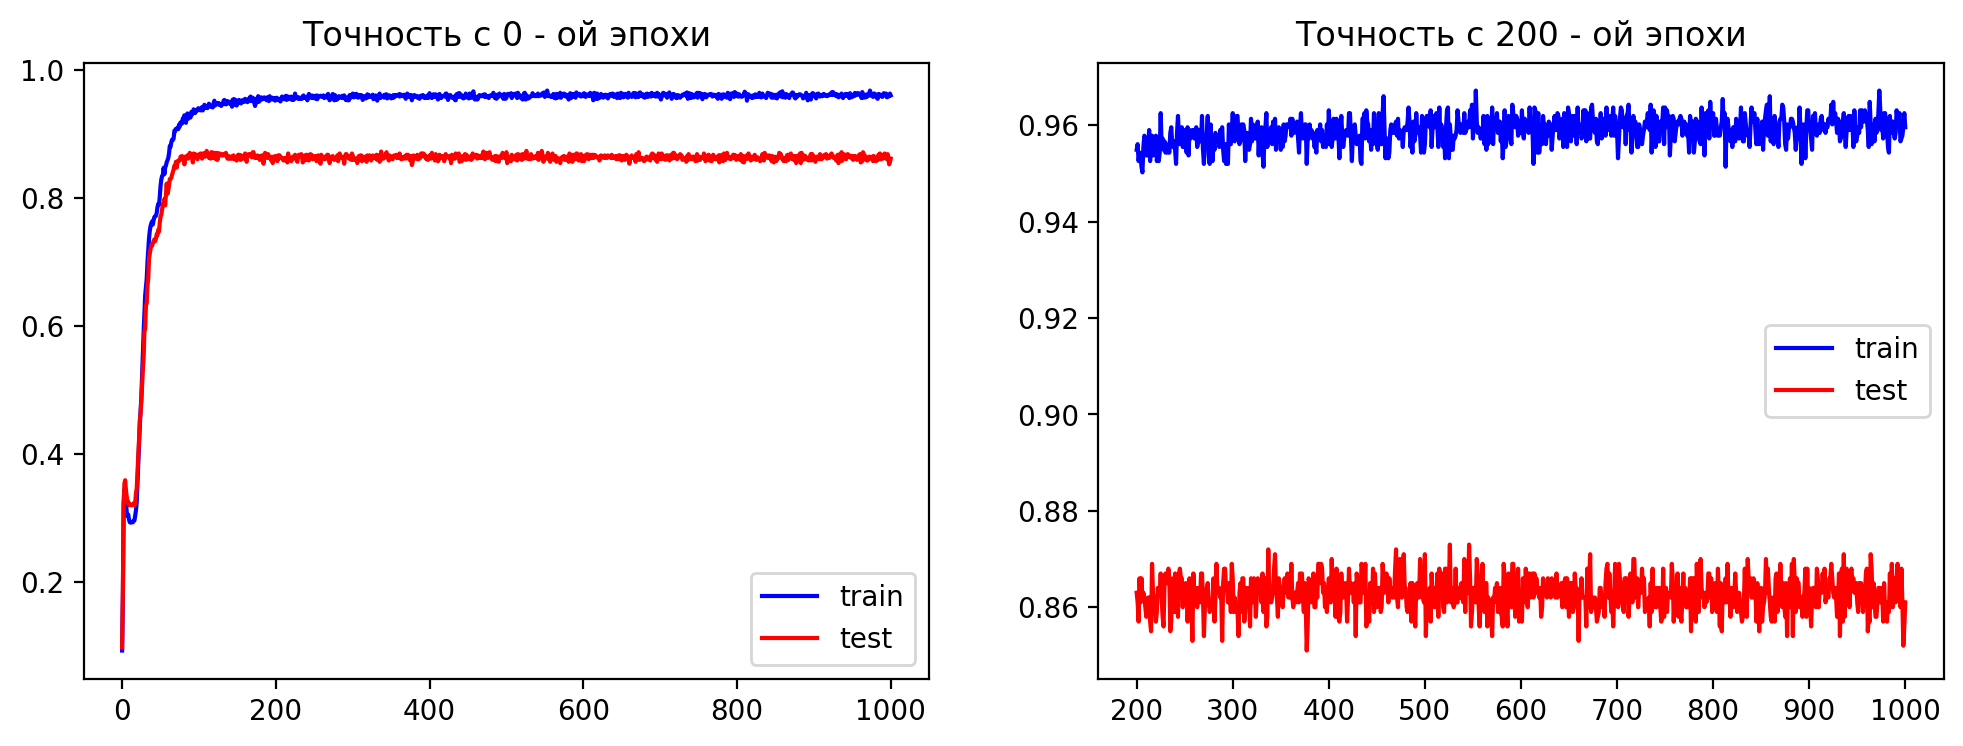

In [ ]:
plots(gat_train.acc, gat_train.t_acc, title = 'Точность')

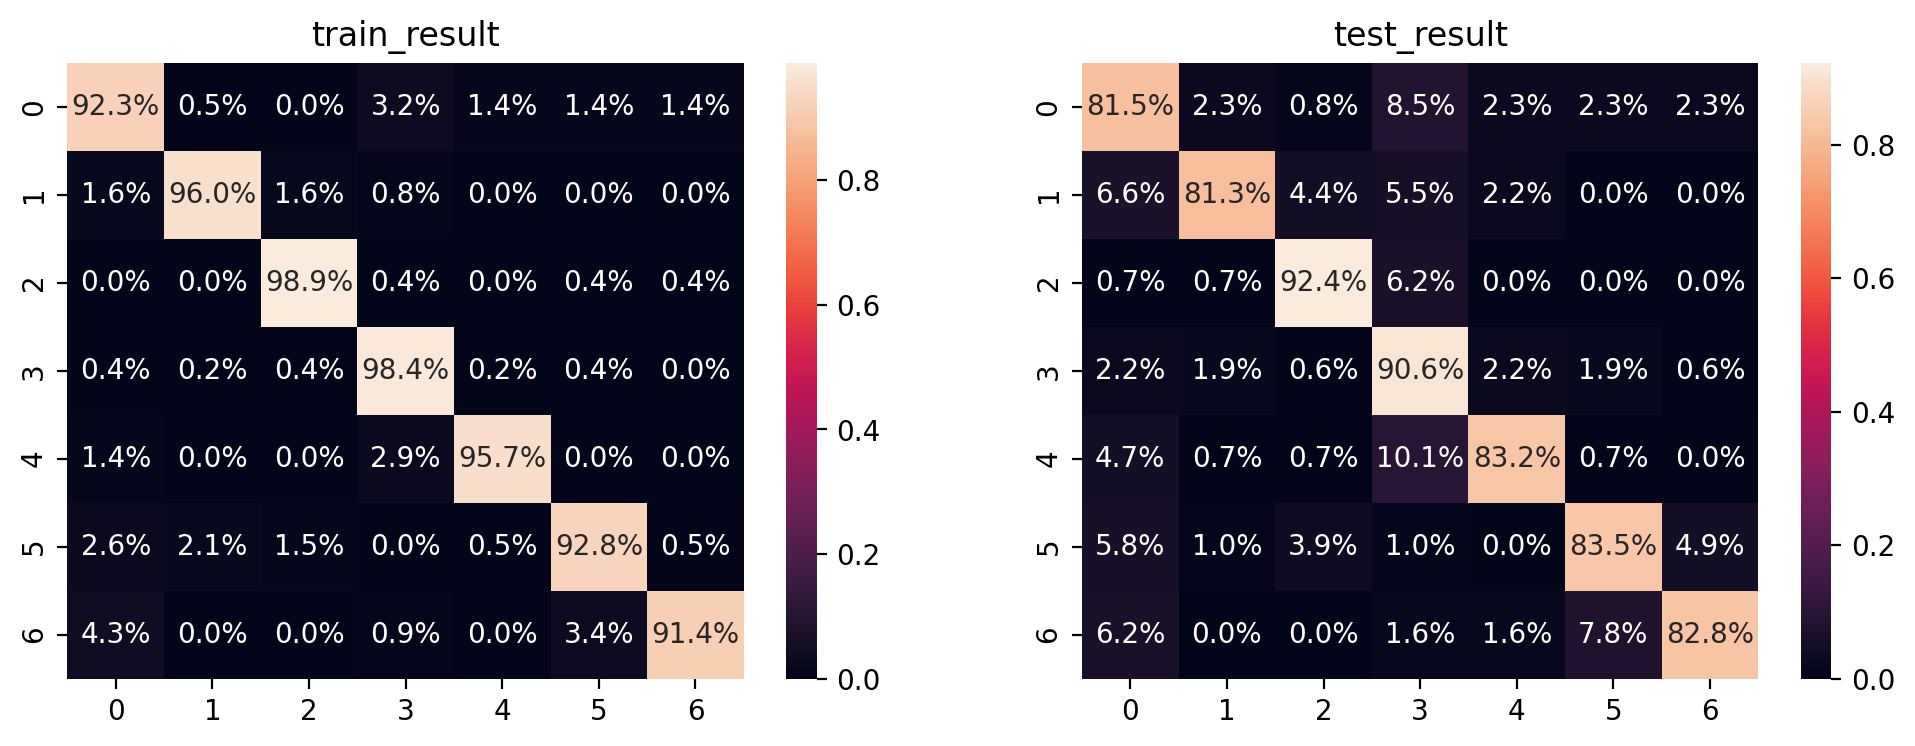

In [ ]:
gat_train.conf_matrix(data)

### б)head1 = 12, head2 = 6

In [ ]:
model_gat = GCN_Gat(n_features = m, num_classes = num_classes, head1 = 12, head2 = 6).to(device)
gat_train = Train(model_gat,
                  w_decay = 1.5e-2,
                  n_epoch = 300)

gat_train.start(data, show = 10)

Epoch    0 | Train Loss: 1.946 | Train Acc:  11.65% | Test Loss: 1.947 | Test Acc: 10.70%
Epoch   10 | Train Loss: 1.417 | Train Acc:  52.05% | Test Loss: 1.435 | Test Acc: 49.30%
Epoch   20 | Train Loss: 0.692 | Train Acc:  78.86% | Test Loss: 0.764 | Test Acc: 76.40%
Epoch   30 | Train Loss: 0.458 | Train Acc:  89.05% | Test Loss: 0.554 | Test Acc: 85.50%
Epoch   40 | Train Loss: 0.356 | Train Acc:  92.10% | Test Loss: 0.480 | Test Acc: 87.50%
Epoch   50 | Train Loss: 0.320 | Train Acc:  92.86% | Test Loss: 0.463 | Test Acc: 87.60%
Epoch   60 | Train Loss: 0.308 | Train Acc:  92.92% | Test Loss: 0.459 | Test Acc: 87.50%
Epoch   70 | Train Loss: 0.295 | Train Acc:  93.15% | Test Loss: 0.449 | Test Acc: 88.00%
Epoch   80 | Train Loss: 0.290 | Train Acc:  93.44% | Test Loss: 0.448 | Test Acc: 87.50%
Epoch   90 | Train Loss: 0.309 | Train Acc:  92.04% | Test Loss: 0.469 | Test Acc: 86.60%
Epoch  100 | Train Loss: 0.288 | Train Acc:  93.38% | Test Loss: 0.455 | Test Acc: 87.70%
Epoch  110

In [ ]:
gat_train.view_results()

,Accuracy,Loss
train,0.939,0.282
test,0.876,0.452


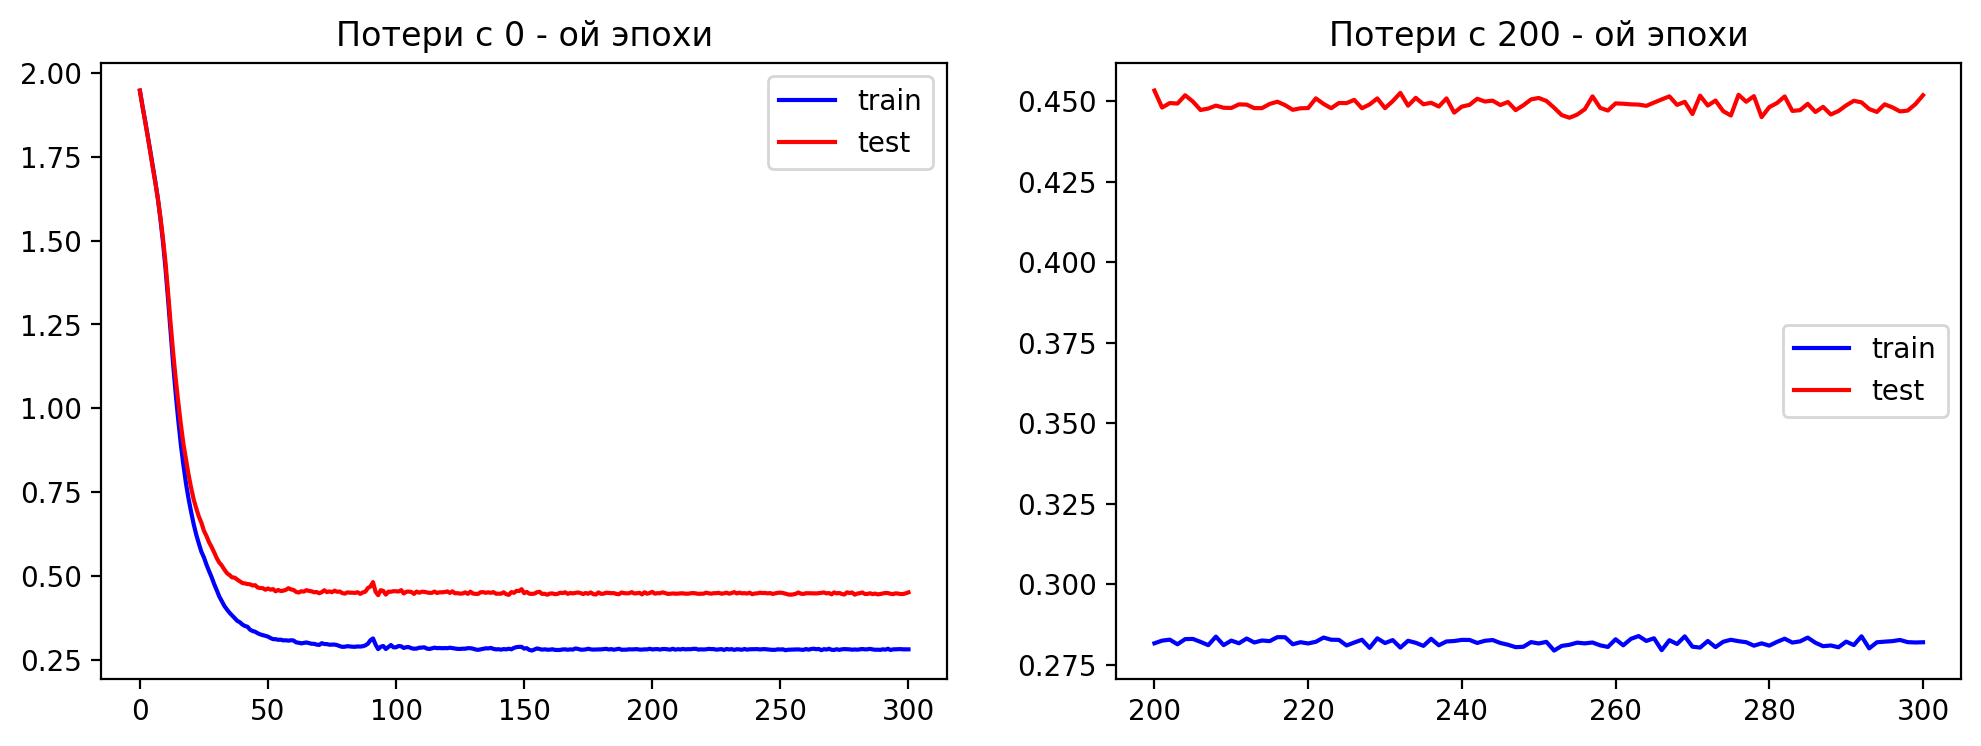

In [ ]:
plots(gat_train.loss, gat_train.t_loss, title = 'Потери')

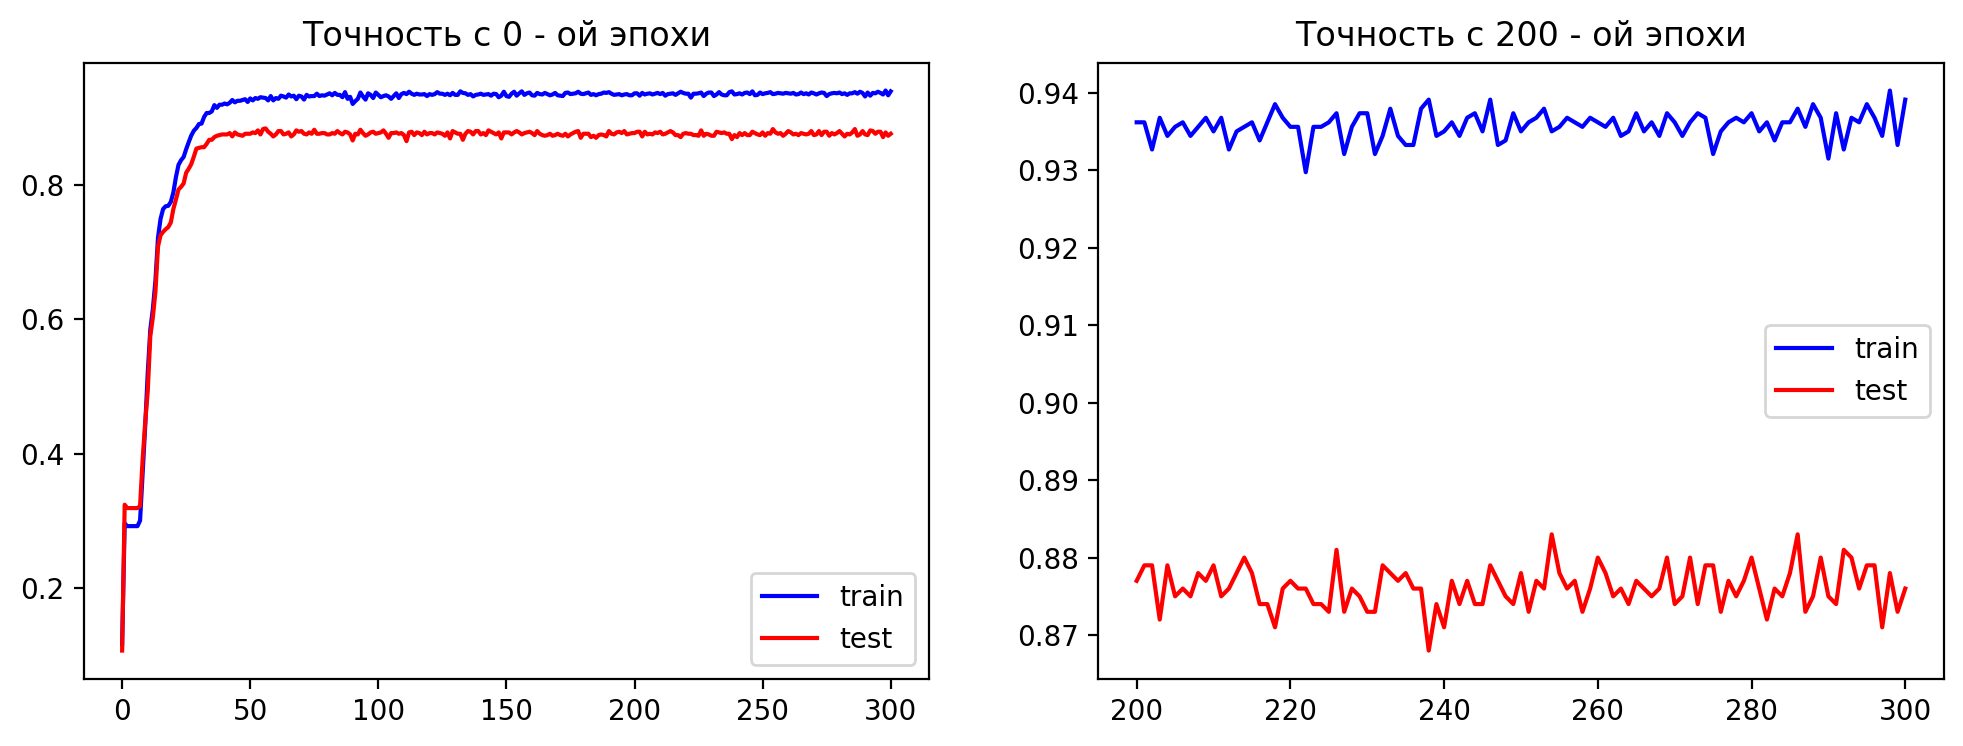

In [ ]:
plots(gat_train.acc, gat_train.t_acc, title = 'Точность')

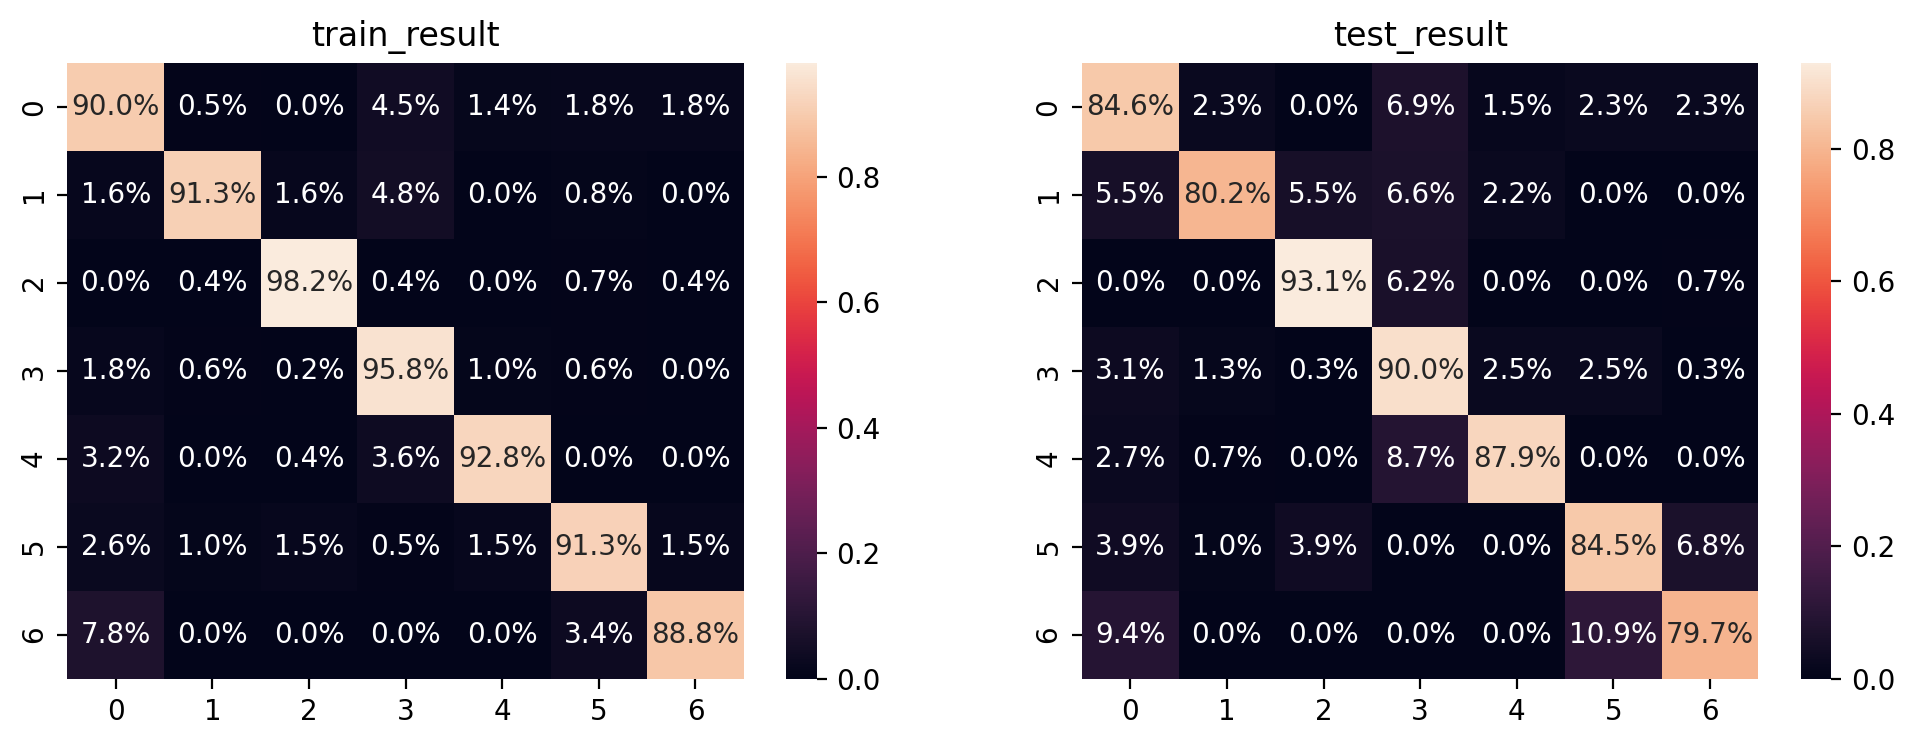

In [ ]:
gat_train.conf_matrix(data)

## Визуализация

In [ ]:
names = ['Linear', 'GCN', 'Sage', 'GAT', 'GAT_many']
colors = ['blue','lightcoral', 'lightblue', 'orange', 'lightgreen']
acc = [0.75,	0.88,	0.884,	0.861,	0.876]
loss = [0.817,	0.427,	0.413,	0.493,	0.447]
# names, acc, loss = names[1:], acc[1:], loss[1:]
G = nx.Graph()
G.add_nodes_from(names)
pos = dict(zip(names, zip(acc, loss)))

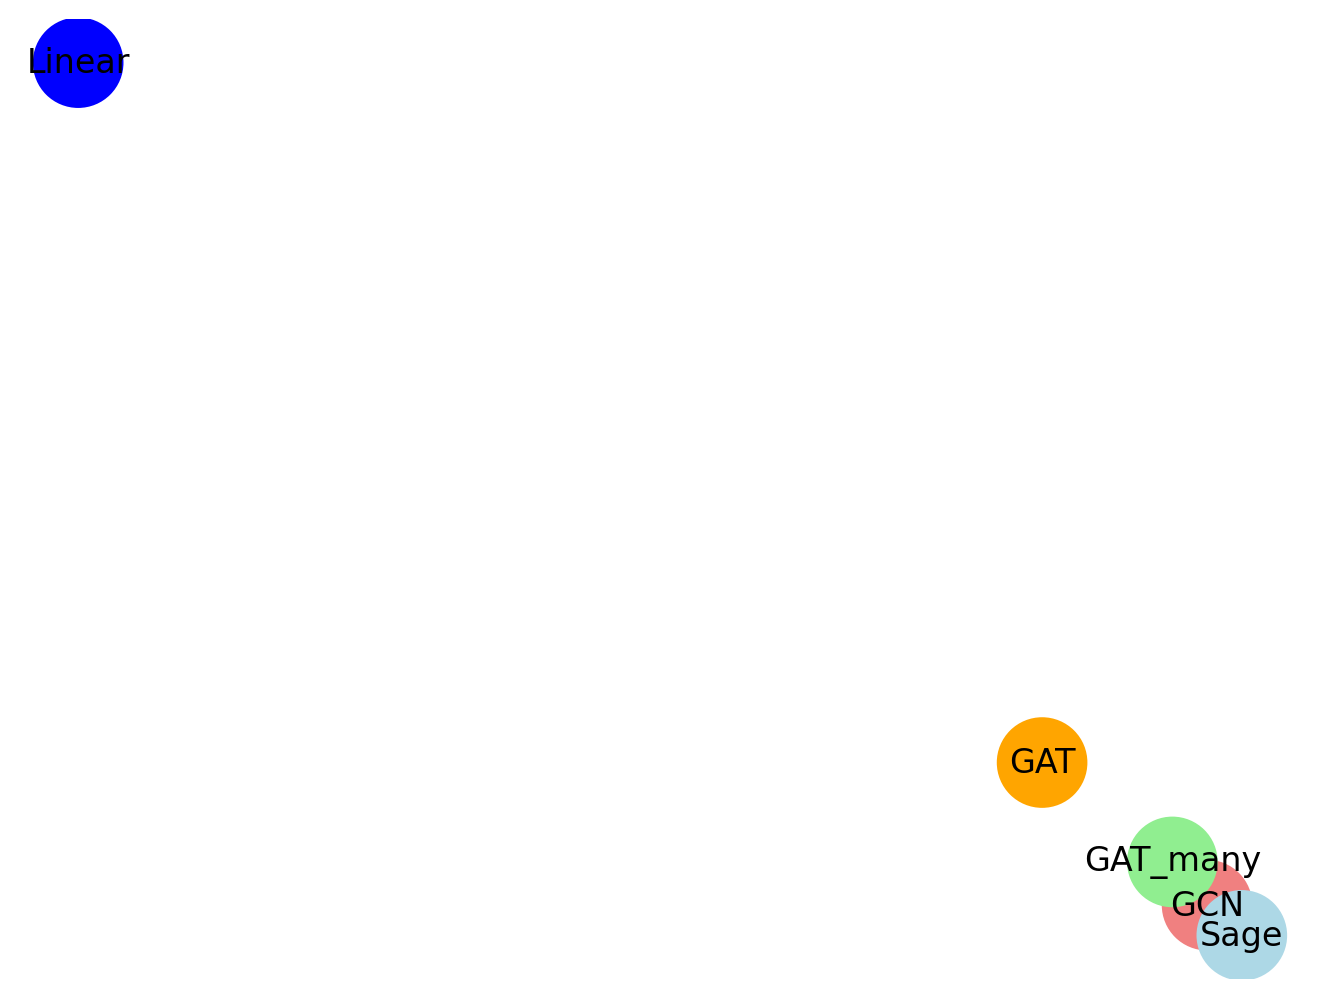

In [ ]:
nx.draw(G, pos = pos, with_labels = True, node_size = 1000, node_color = colors)

## Таблица результатов

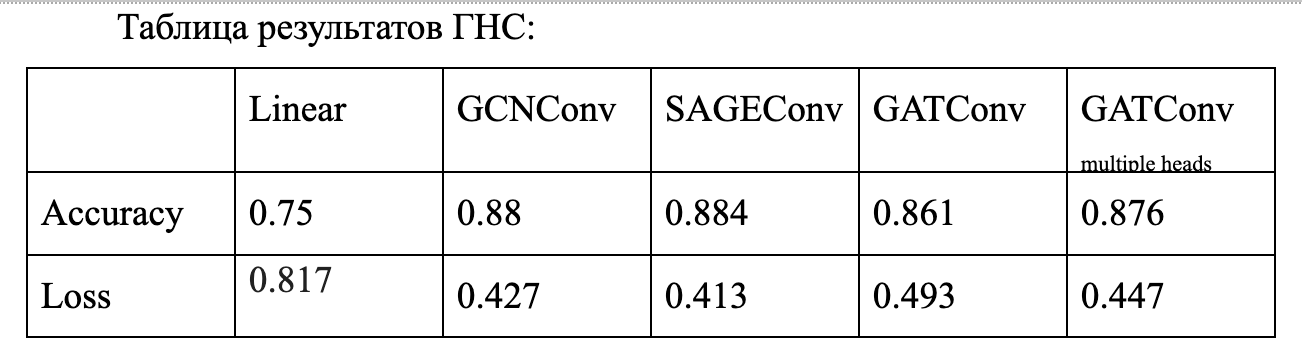

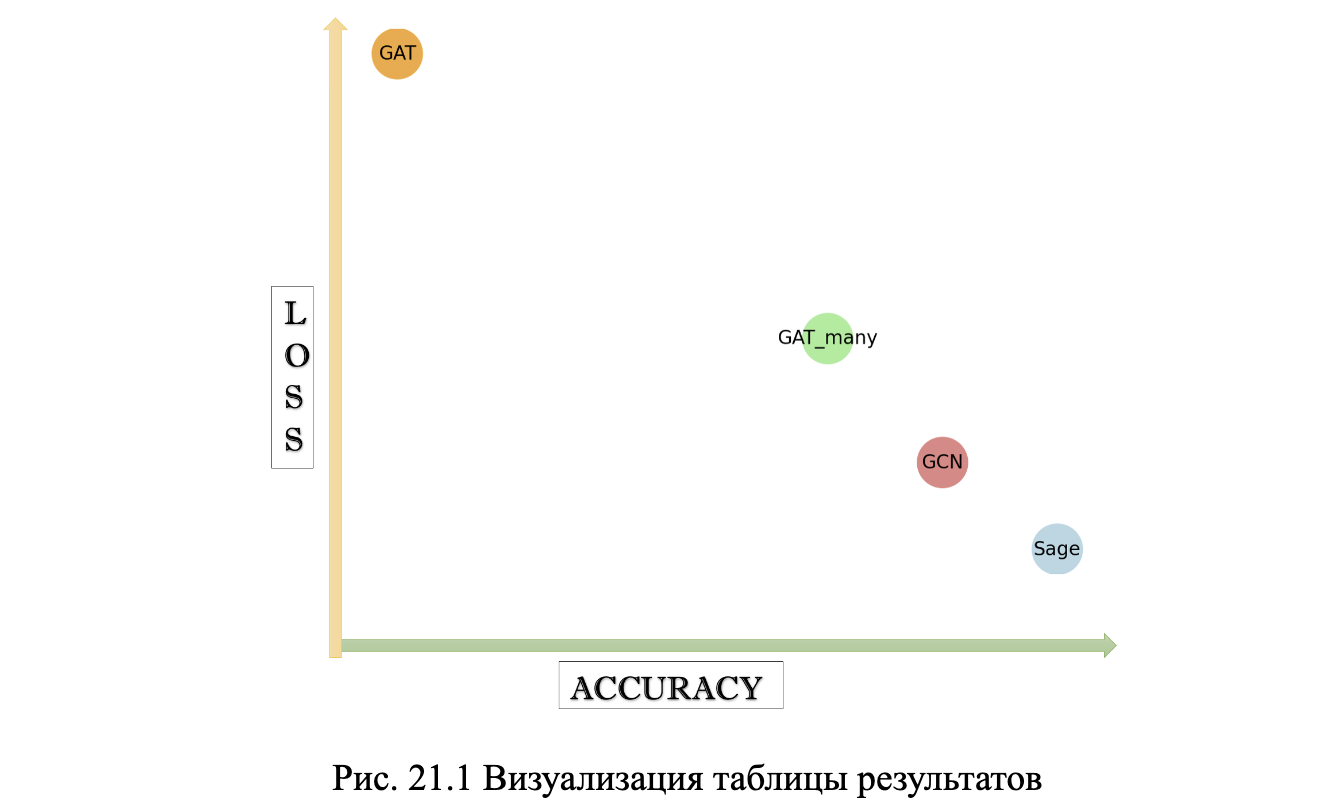

На основании проведённых экспериментов и анализа данных, графовая нейронная сеть SAGEConv продемонстрировала наилучшие результаты по точности предсказаний и функции потерь среди всех рассмотренных моделей. Это связано с её способностью эффективно агрегировать информацию от соседних узлов и учитывать сложные топологические особенности графа. Эти преимущества делают SAGEConv предпочтительным выбором для задач, связанных с анализом графовых данных, и подчёркивают её важность и актуальность в современных исследованиях и приложениях машинного обучения. Тем не менее, если включить в график НС с линейными слоями, можно заметить, что разница между результатами ГНС не так велика:


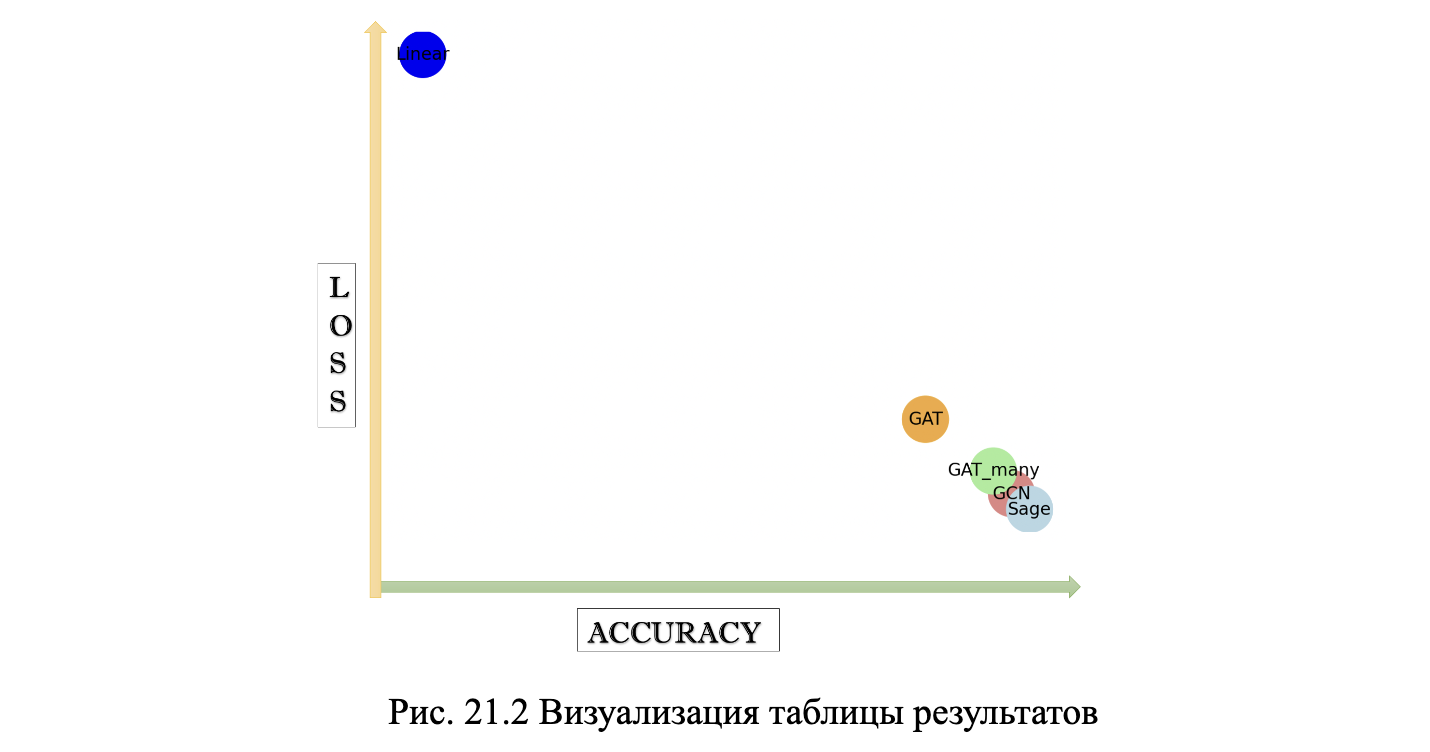

In [ ]:
models = [model_gcn, model_sage, model_gat]
names = ['GCN', 'Sage', 'GAT']

In [ ]:
def show_res(models, names, mask = data.test_mask):
    res = pd.DataFrame({})
    y_pred = models[0](data.x, data.edge_index)[mask].argmax(-1)
    error = th.argwhere(y_pred != data.y[mask]).flatten()
    correct = th.argwhere(y_pred == data.y[mask]).flatten()
    id = th.cat((error[::8], correct[::66]))


    for model, name in zip(models, names):
        pr = model(data.x, data.edge_index)[mask].argmax(-1)
        res[name] = [decode[x.item()] for x in pr[id].to('cpu')]

    res['target'] = [decode[x.item()] for x in data.y[mask][id].to('cpu')]
    res = res.set_index([id.to('cpu').tolist()])

    return res

In [ ]:
decode = {0: "Theory",
1: "Reinforcement_Learning",
2: "Genetic_Algorithms",
3: "Neural_Networks",
4: "Probabilistic_Methods",
5: "Case_Based",
6: "Rule_Learning"}

In [ ]:
df = show_res(models, names)

In [ ]:
# Функция для выделения ячеек
def highlight_cells(x):
    color = 'background-color: '
    light_green = 'lightgreen'
    light_red = 'lightcoral'

    df_styler = pd.DataFrame('', index=x.index, columns=x.columns)
    for column in x.columns[:-1]:  # Пропускаем столбец target
        df_styler[column] = [f'{color}{light_green}' if x.loc[i, column] == x.loc[i, 'target'] else f'{color}{light_red}' for i in x.index]
    return df_styler

# Применяем стилизацию
styled_df = df.style.apply(highlight_cells, axis=None)

In [ ]:
# !pip install docx
# !pip install python-docx

In [ ]:
import pandas as pd
from docx import Document
from docx.shared import RGBColor
from docx.oxml.ns import qn
from docx.oxml import OxmlElement


# Создаём новый документ Word
doc = Document()

# Добавляем заголовок к документу
doc.add_heading('Comparison Table', level=1)

# Добавляем таблицу в документ
table = doc.add_table(rows=1, cols=len(df.columns), style='Table Grid')

# Добавляем заголовки столбцов
hdr_cells = table.rows[0].cells
for i, column in enumerate(df.columns):
    hdr_cells[i].text = column

# Функция для окрашивания текста
def add_colored_cell(cell, text, match):
    cell.text = text
    tc = cell._element
    tcPr = tc.get_or_add_tcPr()
    shd = OxmlElement('w:shd')
    shd.set(qn('w:fill'), 'D3FFCE' if match else 'FFC7CE')
    tcPr.append(shd)

# Заполняем таблицу данными
for index, row in df.iterrows():
    row_cells = table.add_row().cells
    for i, column in enumerate(df.columns):
        if column == "target":
            row_cells[i].text = str(row[column])
        else:
            add_colored_cell(row_cells[i], str(row[column]), row[column] == row['target'])

# Сохраняем документ
doc.save('Comparison_Table.docx')